# üìä An√°lise de Ortogonaliza√ß√£o de Sensores S√≠smicos


Este notebook processa dados s√≠smicos e calcula a magnitude ortogonal (vetor resultante) dos 3 eixos de medida de cada sensor. O objetivo √© encontrar para cada evento s√≠smico qual sensor/canal teve a maior magnitude ortogonal.


## üéØ Objetivos:
- **Processar dados s√≠smicos** de m√∫ltiplos sensores e canais
- **Calcular magnitude ortogonal** usando a f√≥rmula: ‚àö(x¬≤ + y¬≤ + z¬≤)
- **Identificar sensores dominantes** por evento e por canal
- **Gerar relat√≥rios** organizados por Canal H e Canal G


## üìã Estrutura dos Dados:
- **Canal H**: Sensores HH (HHE, HHN, HHZ) e HN (HNE, HNN, HNZ)
- **Canal G**: Sensores GP (GP1, GP2, GPZ)
- **Canal E**: Sensores EL (ELE, ELN, ELZ) - se dispon√≠vel

In [1]:
# Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("‚úÖ Bibliotecas importadas:")
print("   ‚Ä¢ pandas: Manipula√ß√£o de dados")
print("   ‚Ä¢ numpy: C√°lculos matem√°ticos")
print("   ‚Ä¢ matplotlib: Visualiza√ß√µes")
print("   ‚Ä¢ re: Express√µes regulares") 
print("   ‚Ä¢ collections.defaultdict: Estruturas de dados")

print("\nüîß Fun√ß√µes a serem definidas:")
print("   ‚Ä¢ extract_sensor_info_updated(): Extrai informa√ß√µes dos sensores (incluindo MAC)")
print("   ‚Ä¢ calculate_orthogonal_magnitude(): Calcula magnitude 3D")
print("   ‚Ä¢ process_seismic_data_updated(): Processamento completo atualizado")
print("   ‚Ä¢ create_summary_results(): Cria resumo por canal")

‚úÖ Bibliotecas importadas:
   ‚Ä¢ pandas: Manipula√ß√£o de dados
   ‚Ä¢ numpy: C√°lculos matem√°ticos
   ‚Ä¢ matplotlib: Visualiza√ß√µes
   ‚Ä¢ re: Express√µes regulares
   ‚Ä¢ collections.defaultdict: Estruturas de dados

üîß Fun√ß√µes a serem definidas:
   ‚Ä¢ extract_sensor_info_updated(): Extrai informa√ß√µes dos sensores (incluindo MAC)
   ‚Ä¢ calculate_orthogonal_magnitude(): Calcula magnitude 3D
   ‚Ä¢ process_seismic_data_updated(): Processamento completo atualizado
   ‚Ä¢ create_summary_results(): Cria resumo por canal


/home/pedrobook/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# üîß Helper Functions

def calculate_orthogonal_magnitude(x, y, z):
    """
    Calcula a magnitude ortogonal dos 3 eixos usando a f√≥rmula: ‚àö(x¬≤ + y¬≤ + z¬≤)
    
    Args:
        x, y, z (float): Valores de amplitude dos eixos
    
    Returns:
        float: Magnitude ortogonal calculada
    """
    return np.sqrt(x**2 + y**2 + z**2)

print("‚úÖ Fun√ß√µes auxiliares definidas:")
print("   ‚Ä¢ calculate_orthogonal_magnitude(): Calcula magnitude 3D")

# Teste b√°sico da fun√ß√£o
exemplo_canal = "BR.ESM01.00.HHE"
print(f"\nüß™ Teste da fun√ß√£o de magnitude:")
magnitude = calculate_orthogonal_magnitude(3, 4, 5)
print(f"   ‚Ä¢ Magnitude(3, 4, 5) = {magnitude:.2f}")
print(f"   ‚Ä¢ Esperado: 7.07")

‚úÖ Fun√ß√µes auxiliares definidas:
   ‚Ä¢ calculate_orthogonal_magnitude(): Calcula magnitude 3D

üß™ Teste da fun√ß√£o de magnitude:
   ‚Ä¢ Magnitude(3, 4, 5) = 7.07
   ‚Ä¢ Esperado: 7.07


In [3]:
# üîÑ Updated Helper Functions (Including MAC Sensors)

def extract_sensor_info_updated(channel_name):
    """
    Vers√£o atualizada para extrair informa√ß√µes do sensor incluindo s√©rie MAC.
    
    Args:
        channel_name (str): Nome do canal
        Exemplos: 
        - 'BR.ESM05..HHE' (formato antigo)
        - 'SC.MAC11.00.ELE' (formato MAC)
        - 'SC.MAC13.01.HNE' (formato MAC)
    
    Returns:
        tuple: (sensor_name, canal, axis)
    """
    # Padr√£o para capturar diferentes formatos de sensores
    # Formato 1: BR.ESM05 ou SC.MAC11.00 ou SC.MAC13.01
    pattern = r'([A-Z]{2}\.[A-Z0-9]+(?:\.[0-9]+)?(?:\.[0-9]+)?)'
    match = re.search(pattern, channel_name)
    
    if not match:
        return None, None, None
    
    sensor_name = match.group(1)
    
    # Extrair canal e eixo baseado no formato do canal
    
    # Formato MAC: SC.MAC11.00.ELE, SC.MAC13.01.HNE, etc.
    if '.MAC' in channel_name:
        # Extrair o √∫ltimo componente (ELE, ELN, ELZ, HNE, HNN, HNZ)
        components = channel_name.split('.')
        if len(components) >= 4:
            axis = components[-1]  # ELE, ELN, ELZ, HNE, HNN, HNZ
            
            # Determinar canal baseado no eixo
            if axis in ['ELE', 'ELN', 'ELZ']:
                canal = 'E'  # Canal E para sensores EL
            elif axis in ['HNE', 'HNN', 'HNZ']:
                canal = 'H'  # Canal H para sensores HN
            else:
                canal = 'Unknown'
        else:
            return None, None, None
    
    # Formato tradicional BR: ..HH, ..HN, ..GP, ..EL
    elif '..HH' in channel_name:
        canal = 'H'
        axis = channel_name.split('..')[-1]  # HHE, HHN, HHZ
    elif '..HN' in channel_name:
        canal = 'H'
        axis = channel_name.split('..')[-1]  # HNE, HNN, HNZ
    elif '..GP' in channel_name:
        canal = 'G'
        axis = channel_name.split('..')[-1]  # GP1, GP2, GPZ
    elif '..EL' in channel_name:
        canal = 'E'  # Considerando EL como um canal especial
        axis = channel_name.split('..')[-1]  # ELE, ELN, ELZ
    else:
        # Casos especiais
        if '.HH' in channel_name:
            canal = 'H'
            axis = channel_name.split('.')[-1]  # HH1, HH2, HHZ
        else:
            canal = 'Unknown'
            axis = channel_name.split('..')[-1] if '..' in channel_name else channel_name.split('.')[-1]
    
    return sensor_name, canal, axis

# Fun√ß√£o de processamento atualizada
def process_seismic_data_updated(csv_file):
    """
    Vers√£o atualizada da fun√ß√£o de processamento incluindo sensores MAC.
    """
    # Carregar dados
    df = pd.read_csv(csv_file)
    
    # Dicion√°rio para armazenar dados organizados por event_id e sensor
    data_by_event = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    # Organizar dados por event_id, sensor, canal e eixo
    for _, row in df.iterrows():
        event_id = row['event_id']
        channel_name = row['channel_name']
        max_amplitude = abs(row['max_amplitude'])  # Usar valor absoluto
        
        sensor_name, canal, axis = extract_sensor_info_updated(channel_name)
        
        if sensor_name and canal and axis:
            data_by_event[event_id][sensor_name][canal][axis] = max_amplitude
    
    # Lista para armazenar os resultados
    results = []
    
    # Processar cada evento
    for event_id, sensors_data in data_by_event.items():
        max_magnitude = 0
        best_sensor = None
        best_canal = None
        event_results = {}
        
        for sensor_name, canais_data in sensors_data.items():
            for canal, axes_data in canais_data.items():
                # Definir mapeamento de eixos para cada canal (ATUALIZADO)
                if canal == 'H':
                    # Canal H: HHE, HHN, HHZ ou HNE, HNN, HNZ ou HH1, HH2, HHZ
                    axis_map = {
                        'x': ['HHE', 'HNE', 'HH1'],
                        'y': ['HHN', 'HNN', 'HH2'], 
                        'z': ['HHZ', 'HHZ', 'HHZ']
                    }
                elif canal == 'G':
                    # Canal G: GP1, GP2, GPZ
                    axis_map = {
                        'x': ['GP1'],
                        'y': ['GP2'],
                        'z': ['GPZ']
                    }
                elif canal == 'E':
                    # Canal E: ELE, ELN, ELZ (incluindo sensores MAC)
                    axis_map = {
                        'x': ['ELE'],
                        'y': ['ELN'],
                        'z': ['ELZ']
                    }
                else:
                    continue
                
                # Extrair valores para x, y, z
                x_val = None
                y_val = None
                z_val = None
                
                for axis, amplitude in axes_data.items():
                    if axis in axis_map['x']:
                        x_val = amplitude
                    elif axis in axis_map['y']:
                        y_val = amplitude
                    elif axis in axis_map['z']:
                        z_val = amplitude
                
                # Calcular magnitude ortogonal se tivermos os 3 eixos
                if x_val is not None and y_val is not None and z_val is not None:
                    magnitude = calculate_orthogonal_magnitude(x_val, y_val, z_val)
                    
                    # Armazenar resultado
                    key = f"{sensor_name}_{canal}"
                    event_results[key] = {
                        'event_id': event_id,
                        'sensor': sensor_name,
                        'canal': canal,
                        'x_amplitude': x_val,
                        'y_amplitude': y_val,
                        'z_amplitude': z_val,
                        'orthogonal_magnitude': magnitude
                    }
                    
                    # Verificar se √© o maior
                    if magnitude > max_magnitude:
                        max_magnitude = magnitude
                        best_sensor = sensor_name
                        best_canal = canal
        
        # Adicionar todos os resultados do evento
        for key, result in event_results.items():
            result['is_max'] = (result['sensor'] == best_sensor and result['canal'] == best_canal)
            results.append(result)
    
    return pd.DataFrame(results)

# Teste das fun√ß√µes atualizadas
print("‚úÖ Fun√ß√µes atualizadas definidas (incluindo sensores MAC):")
print("   ‚Ä¢ extract_sensor_info_updated(): Inclui formato MAC")
print("   ‚Ä¢ process_seismic_data_updated(): Processamento completo atualizado")

# Exemplos de teste com os novos formatos
print(f"\nüîç Exemplos de sensores MAC:")
exemplos_mac = [
    "SC.MAC11.00.ELE",
    "SC.MAC11.00.ELN", 
    "SC.MAC11.00.ELZ",
    "SC.MAC11.01.HNE",
    "SC.MAC13.01.HNN",
    "SC.MAC13.01.HNZ"
]

for exemplo in exemplos_mac:
    sensor, canal, axis = extract_sensor_info_updated(exemplo)
    print(f"   ‚Ä¢ {exemplo:20s} ‚Üí Sensor: {sensor:15s} | Canal: {canal} | Eixo: {axis}")

print(f"\nüîç Exemplos de sensores BR (compatibilidade):")
exemplos_br = ["BR.ESM05..HHE", "BR.ESM06..GP1", "BR.ESM07..ELE"]
for exemplo in exemplos_br:
    sensor, canal, axis = extract_sensor_info_updated(exemplo)
    print(f"   ‚Ä¢ {exemplo:20s} ‚Üí Sensor: {sensor:15s} | Canal: {canal} | Eixo: {axis}")

print(f"\nüìã Canais suportados:")
print(f"   ‚Ä¢ Canal H: Sensores HH, HN (BR) + HN (MAC)")
print(f"   ‚Ä¢ Canal G: Sensores GP (BR)")
print(f"   ‚Ä¢ Canal E: Sensores EL (BR) + EL (MAC)")
print(f"\nüí° Para usar as fun√ß√µes atualizadas, substitua:")
print(f"   process_seismic_data() ‚Üí process_seismic_data_updated()")

‚úÖ Fun√ß√µes atualizadas definidas (incluindo sensores MAC):
   ‚Ä¢ extract_sensor_info_updated(): Inclui formato MAC
   ‚Ä¢ process_seismic_data_updated(): Processamento completo atualizado

üîç Exemplos de sensores MAC:
   ‚Ä¢ SC.MAC11.00.ELE      ‚Üí Sensor: SC.MAC11.00     | Canal: E | Eixo: ELE
   ‚Ä¢ SC.MAC11.00.ELN      ‚Üí Sensor: SC.MAC11.00     | Canal: E | Eixo: ELN
   ‚Ä¢ SC.MAC11.00.ELZ      ‚Üí Sensor: SC.MAC11.00     | Canal: E | Eixo: ELZ
   ‚Ä¢ SC.MAC11.01.HNE      ‚Üí Sensor: SC.MAC11.01     | Canal: H | Eixo: HNE
   ‚Ä¢ SC.MAC13.01.HNN      ‚Üí Sensor: SC.MAC13.01     | Canal: H | Eixo: HNN
   ‚Ä¢ SC.MAC13.01.HNZ      ‚Üí Sensor: SC.MAC13.01     | Canal: H | Eixo: HNZ

üîç Exemplos de sensores BR (compatibilidade):
   ‚Ä¢ BR.ESM05..HHE        ‚Üí Sensor: BR.ESM05        | Canal: H | Eixo: HHE
   ‚Ä¢ BR.ESM06..GP1        ‚Üí Sensor: BR.ESM06        | Canal: G | Eixo: GP1
   ‚Ä¢ BR.ESM07..ELE        ‚Üí Sensor: BR.ESM07        | Canal: E | Eixo: ELE

üìã Canais sup

In [4]:
# ‚öôÔ∏è Define Data Processing Functions

def create_summary_results(df):
    """
    Cria um resumo com a maior magnitude de cada canal (H e G) por evento.
    
    Args:
        df (pd.DataFrame): DataFrame com todos os resultados
    
    Returns:
        pd.DataFrame: DataFrame com resumo organizado por canal
    """
    # Lista para armazenar os resultados finais
    final_results = []
    
    # Agrupar por event_id
    for event_id in df['event_id'].unique():
        event_data = df[df['event_id'] == event_id]
        
        # Separar dados por canal
        h_data = event_data[event_data['canal'] == 'H']
        g_data = event_data[event_data['canal'] == 'G']
        e_data = event_data[event_data['canal'] == 'E']  # Incluir canal E se existir
        
        # Encontrar maior magnitude do Canal H
        if len(h_data) > 0:
            max_h = h_data.loc[h_data['orthogonal_magnitude'].idxmax()]
            final_results.append({
                'event_id': event_id,
                'canal': 'Canal_H',
                'max_magnitude': max_h['orthogonal_magnitude'],
                'sensor': max_h['sensor'],
                'x_amplitude': max_h['x_amplitude'],
                'y_amplitude': max_h['y_amplitude'],
                'z_amplitude': max_h['z_amplitude']
            })
        
        # Encontrar maior magnitude do Canal G
        if len(g_data) > 0:
            max_g = g_data.loc[g_data['orthogonal_magnitude'].idxmax()]
            final_results.append({
                'event_id': event_id,
                'canal': 'Canal_G',
                'max_magnitude': max_g['orthogonal_magnitude'],
                'sensor': max_g['sensor'],
                'x_amplitude': max_g['x_amplitude'],
                'y_amplitude': max_g['y_amplitude'],
                'z_amplitude': max_g['z_amplitude']
            })
        
        # Encontrar maior magnitude do Canal E (se existir)
        if len(e_data) > 0:
            max_e = e_data.loc[e_data['orthogonal_magnitude'].idxmax()]
            final_results.append({
                'event_id': event_id,
                'canal': 'Canal_E',
                'max_magnitude': max_e['orthogonal_magnitude'],
                'sensor': max_e['sensor'],
                'x_amplitude': max_e['x_amplitude'],
                'y_amplitude': max_e['y_amplitude'],
                'z_amplitude': max_e['z_amplitude']
            })
    
    # Converter para DataFrame e ordenar
    summary_df = pd.DataFrame(final_results)
    summary_df = summary_df.sort_values(['event_id', 'canal'])
    
    return summary_df

print("‚úÖ Fun√ß√µes de processamento definidas:")
print("   ‚Ä¢ create_summary_results(): Cria resumo por canal")
print("   ‚Ä¢ process_seismic_data_updated(): Fun√ß√£o principal (definida posteriormente)")

‚úÖ Fun√ß√µes de processamento definidas:
   ‚Ä¢ create_summary_results(): Cria resumo por canal
   ‚Ä¢ process_seismic_data_updated(): Fun√ß√£o principal (definida posteriormente)


In [5]:
# üìÇ Load and Process ALL Seismic Data Files (Updated for MAC Sensors)

import os
import glob
from pathlib import Path

# Definir pasta com os arquivos CSV
data_folder = '/home/pedrobook/braskem/data_analysis/dados_sismologicos/Eventos/'
# data_folder = '/content/'  # Para Google Colab

print("üîÑ Iniciando processamento de TODOS os arquivos CSV s√≠smicos...")
print(f"üìÅ Pasta de dados: {data_folder}")

# Buscar todos os arquivos CSV na pasta
csv_files = glob.glob(os.path.join(data_folder, "*.csv"))
csv_files = [f for f in csv_files if not f.endswith('_coords.csv')]  # Excluir arquivos de coordenadas

print(f"üìä Arquivos CSV encontrados: {len(csv_files)}")
for i, file in enumerate(csv_files, 1):
    filename = os.path.basename(file)
    print(f"   {i:2d}. {filename}")

# Dicion√°rio para armazenar resultados de cada arquivo
all_results = {}
all_summaries = {}

print(f"\nüîÑ Processando cada arquivo...")

try:
    for i, csv_file in enumerate(csv_files, 1):
        filename = os.path.basename(csv_file)
        print(f"\n{'='*60}")
        print(f"üìÇ PROCESSANDO ARQUIVO {i}/{len(csv_files)}: {filename}")
        print(f"{'='*60}")
        
        try:
            # Processar dados s√≠smicos usando a fun√ß√£o ATUALIZADA
            file_results = process_seismic_data_updated(csv_file)
            
            print(f"‚úÖ Arquivo processado com sucesso!")
            print(f"üìä Resultados: {len(file_results):,} registros")
            print(f"üéØ Eventos √∫nicos: {file_results['event_id'].nunique():,}")
            print(f"üîß Sensores √∫nicos: {file_results['sensor'].nunique()}")
            print(f"üåê Canais encontrados: {sorted(file_results['canal'].unique())}")
            
            # Verificar sensores MAC
            mac_sensors = file_results[file_results['sensor'].str.contains('MAC', na=False)]
            if len(mac_sensors) > 0:
                print(f"üîç Sensores MAC: {mac_sensors['sensor'].nunique()} √∫nicos")
            
            # Adicionar coluna com nome do arquivo para identifica√ß√£o
            file_results['source_file'] = filename
            
            # Armazenar resultados
            all_results[filename] = file_results
            
            # Criar resumo para este arquivo
            file_summary = create_summary_results(file_results)
            file_summary['source_file'] = filename
            all_summaries[filename] = file_summary
            
            print(f"üìã Resumo: {len(file_summary):,} registros")
            
        except Exception as e:
            print(f"‚ùå Erro ao processar {filename}: {e}")
            continue
    
    # Combinar todos os resultados
    if all_results:
        results_df = pd.concat(all_results.values(), ignore_index=True)
        summary_df = pd.concat(all_summaries.values(), ignore_index=True)
        
        print(f"\n{'='*60}")
        print(f"üéâ PROCESSAMENTO GLOBAL CONCLU√çDO")
        print(f"{'='*60}")
        print(f"‚úÖ Arquivos processados com sucesso: {len(all_results)}")
        print(f"üìä Total de resultados: {len(results_df):,} registros")
        print(f"üéØ Total de eventos √∫nicos: {results_df['event_id'].nunique():,}")
        print(f"üîß Total de sensores √∫nicos: {results_df['sensor'].nunique()}")
        print(f"üåê Canais encontrados: {sorted(results_df['canal'].unique())}")
        print(f"üìã Total no resumo: {len(summary_df):,} registros")
        
        # Estat√≠sticas por arquivo
        print(f"\nüìÇ Estat√≠sticas por arquivo:")
        file_stats = results_df.groupby('source_file').agg({
            'event_id': 'nunique',
            'sensor': 'nunique', 
            'orthogonal_magnitude': 'count'
        }).round(2)
        file_stats.columns = ['Eventos', 'Sensores', 'Registros']
        print(file_stats.to_string())
        
    else:
        print(f"‚ùå Nenhum arquivo foi processado com sucesso!")
        
except Exception as e:
    print(f"‚ùå Erro geral durante o processamento: {e}")
    print(f"   ‚Ä¢ Colunas: {list(results_df.columns)}")
    print(f"   ‚Ä¢ Tipos de dados:")
    for col in results_df.columns:
        print(f"     - {col}: {results_df[col].dtype}")
        
    # Estat√≠sticas por canal (incluindo E se presente)
    if len(results_df) > 0:
        canal_counts = results_df['canal'].value_counts()
        print(f"\nüìà Distribui√ß√£o por canal nos dados completos:")
        for canal, count in canal_counts.items():
            percentage = (count / len(results_df)) * 100
            print(f"   ‚Ä¢ Canal {canal}: {count:,} registros ({percentage:.1f}%)")
        
except FileNotFoundError:
    print("‚ùå Erro: Arquivo n√£o encontrado!")
    print("üìù Para usar no Google Colab:")
    print("   1. Fa√ßa upload do arquivo eventsA001_cut25seg.csv")
    print("   2. Ou conecte ao Google Drive e ajuste o caminho")
    print("   3. Ou use: csv_file = '/content/nome_do_arquivo.csv'")
except Exception as e:
    print(f"‚ùå Erro durante o processamento: {e}")
    
print(f"\nüÜï NOVOS SENSORES SUPORTADOS:")
print(f"   ‚Ä¢ SC.MAC11.00.ELE/ELN/ELZ (Canal E)")
print(f"   ‚Ä¢ SC.MAC11.01.HNE/HNN/HNZ (Canal H)")
print(f"   ‚Ä¢ SC.MAC13.00.ELE/ELN/ELZ (Canal E)")
print(f"   ‚Ä¢ SC.MAC13.01.HNE/HNN/HNZ (Canal H)")

üîÑ Iniciando processamento de TODOS os arquivos CSV s√≠smicos...
üìÅ Pasta de dados: /home/pedrobook/braskem/data_analysis/dados_sismologicos/Eventos/
üìä Arquivos CSV encontrados: 10
    1. eventsNDA1_cut25seg.csv
    2. eventsNDA0_cut25seg.csv
    3. eventsA002_cut25seg.csv
    4. eventsD001_cut25seg.csv
    5. feature_correlations.csv
    6. eventsA001_cut25seg.csv
    7. eventsF001_cut25seg.csv
    8. eventsNDA_cut25seg.csv
    9. eventsA003_cut25seg.csv
   10. eventsE001_cut25seg.csv

üîÑ Processando cada arquivo...

üìÇ PROCESSANDO ARQUIVO 1/10: eventsNDA1_cut25seg.csv
‚úÖ Arquivo processado com sucesso!
üìä Resultados: 4,884 registros
üéØ Eventos √∫nicos: 1,218
üîß Sensores √∫nicos: 16
üåê Canais encontrados: ['E', 'G', 'H']
üîç Sensores MAC: 6 √∫nicos
‚úÖ Arquivo processado com sucesso!
üìä Resultados: 4,884 registros
üéØ Eventos √∫nicos: 1,218
üîß Sensores √∫nicos: 16
üåê Canais encontrados: ['E', 'G', 'H']
üîç Sensores MAC: 6 √∫nicos
üìã Resumo: 2,784 registr

In [6]:
# üìã Create Summary Results

print("üîÑ Criando resumo organizado por canais...")

try:
    # Criar resumo dos resultados
    summary_df = create_summary_results(results_df)
    
    print("‚úÖ Resumo criado com sucesso!")
    print(f"üìä Total de linhas no resumo: {len(summary_df):,}")
    print(f"üéØ Eventos √∫nicos no resumo: {summary_df['event_id'].nunique():,}")
    
    # Verificar distribui√ß√£o por canal
    canal_distribution = summary_df['canal'].value_counts()
    print(f"\nüìà Distribui√ß√£o por canal:")
    for canal, count in canal_distribution.items():
        percentage = (count / len(summary_df)) * 100
        print(f"   ‚Ä¢ {canal}: {count:,} registros ({percentage:.1f}%)")
    
    # Verificar se temos 2 linhas por evento (idealmente)
    events_per_line = summary_df.groupby('event_id').size()
    print(f"\nüîç An√°lise de completude:")
    print(f"   ‚Ä¢ Eventos com 2 canais: {(events_per_line == 2).sum():,}")
    print(f"   ‚Ä¢ Eventos com 1 canal: {(events_per_line == 1).sum():,}")
    print(f"   ‚Ä¢ Outros casos: {(events_per_line > 2).sum():,}")
    
    print(f"\nüìã Colunas do resumo: {list(summary_df.columns)}")
    
except NameError:
    print("‚ùå Erro: Execute primeiro a c√©lula de processamento dos dados!")
except Exception as e:
    print(f"‚ùå Erro ao criar resumo: {e}")

üîÑ Criando resumo organizado por canais...
‚úÖ Resumo criado com sucesso!
üìä Total de linhas no resumo: 33,356
üéØ Eventos √∫nicos no resumo: 14,713

üìà Distribui√ß√£o por canal:
   ‚Ä¢ Canal_H: 14,203 registros (42.6%)
   ‚Ä¢ Canal_G: 11,170 registros (33.5%)
   ‚Ä¢ Canal_E: 7,983 registros (23.9%)

üîç An√°lise de completude:
   ‚Ä¢ Eventos com 2 canais: 8,255
   ‚Ä¢ Eventos com 1 canal: 1,264
   ‚Ä¢ Outros casos: 5,194

üìã Colunas do resumo: ['event_id', 'canal', 'max_magnitude', 'sensor', 'x_amplitude', 'y_amplitude', 'z_amplitude']
‚úÖ Resumo criado com sucesso!
üìä Total de linhas no resumo: 33,356
üéØ Eventos √∫nicos no resumo: 14,713

üìà Distribui√ß√£o por canal:
   ‚Ä¢ Canal_H: 14,203 registros (42.6%)
   ‚Ä¢ Canal_G: 11,170 registros (33.5%)
   ‚Ä¢ Canal_E: 7,983 registros (23.9%)

üîç An√°lise de completude:
   ‚Ä¢ Eventos com 2 canais: 8,255
   ‚Ä¢ Eventos com 1 canal: 1,264
   ‚Ä¢ Outros casos: 5,194

üìã Colunas do resumo: ['event_id', 'canal', 'max_magnit

In [7]:
# üíæ Verify Results Ready for CSV Creation

print("üíæ Verificando se os resultados est√£o prontos para cria√ß√£o de CSV...")

try:
    if 'all_results' not in locals() or not all_results:
        print("‚ùå Erro: Execute primeiro o processamento dos dados!")
        print("üí° Execute a c√©lula 'üìÇ Load and Process ALL Seismic Data Files' primeiro")
    else:
        print("‚úÖ Resultados est√£o prontos!")
        print(f"üìä Arquivos processados: {len(all_results)}")
        print(f"üìã Total de eventos √∫nicos: {sum(df['event_id'].nunique() for df in all_results.values()):,}")
        
        print(f"\nüìù Para criar os arquivos CSV individuais:")
        print(f"   üëâ Execute a pr√≥xima c√©lula: 'üìÑ Create Individual CSV Files'")
        
        print(f"\nüìä Resumo dos dados dispon√≠veis:")
        for filename, file_results in all_results.items():
            file_summary = all_summaries[filename] 
            print(f"   üìÅ {filename}")
            print(f"      ‚Ä¢ Eventos: {file_results['event_id'].nunique():,}")
            print(f"      ‚Ä¢ Registros resumo: {len(file_summary):,}")
            print(f"      ‚Ä¢ Canais: {sorted(file_results['canal'].unique())}")
        
        print(f"\nüéØ PASTA DE DESTINO: resultados_csv/ (formato simplificado)")
        
except Exception as e:
    print(f"‚ùå Erro ao verificar resultados: {e}")
    import traceback
    traceback.print_exc()

üíæ Verificando se os resultados est√£o prontos para cria√ß√£o de CSV...
‚úÖ Resultados est√£o prontos!
üìä Arquivos processados: 9
üìã Total de eventos √∫nicos: 21,928

üìù Para criar os arquivos CSV individuais:
   üëâ Execute a pr√≥xima c√©lula: 'üìÑ Create Individual CSV Files'

üìä Resumo dos dados dispon√≠veis:
   üìÅ eventsNDA1_cut25seg.csv
      ‚Ä¢ Eventos: 1,218
      ‚Ä¢ Registros resumo: 2,784
      ‚Ä¢ Canais: ['E', 'G', 'H']
   üìÅ eventsNDA0_cut25seg.csv
      ‚Ä¢ Eventos: 5,989
      ‚Ä¢ Registros resumo: 13,273
      ‚Ä¢ Canais: ['E', 'G', 'H']
   üìÅ eventsA002_cut25seg.csv
      ‚Ä¢ Eventos: 1,352
      ‚Ä¢ Registros resumo: 3,033
      ‚Ä¢ Canais: ['E', 'G', 'H']
   üìÅ eventsD001_cut25seg.csv
      ‚Ä¢ Eventos: 1,806
      ‚Ä¢ Registros resumo: 3,902
      ‚Ä¢ Canais: ['E', 'G', 'H']
   üìÅ eventsA001_cut25seg.csv
      ‚Ä¢ Eventos: 2,070
      ‚Ä¢ Registros resumo: 5,353
      ‚Ä¢ Canais: ['E', 'G', 'H']
   üìÅ eventsF001_cut25seg.csv
      ‚Ä¢ Evento

In [8]:
# üìÑ Create Individual CSV Files for Each Processed File

print("üìÑ Criando arquivos CSV individuais para cada arquivo processado...")

try:
    if 'all_results' not in locals() or not all_results:
        print("‚ùå Erro: Execute primeiro o processamento dos dados!")
    else:
        # Criar pasta de resultados
        # output_folder = '/content/resultados_csv/'  # Para Colab
        output_folder = '/home/pedrobook/braskem/data_analysis/resultados_csv/'  # Para local
        
        import os
        os.makedirs(output_folder, exist_ok=True)
        
        print(f"üìÅ Pasta de resultados: {output_folder}")
        
        # Contador de arquivos criados
        files_created = 0
        
        # Criar arquivo CSV para cada arquivo processado
        for filename, file_summary in all_summaries.items():
            # Nome base do arquivo (sem extens√£o)
            base_name = filename.replace('.csv', '')
            
            # Arquivo de sa√≠da para este arquivo espec√≠fico
            output_file = os.path.join(output_folder, f'{base_name}_results.csv')
            
            # Salvar resumo (formato principal solicitado)
            file_summary.to_csv(output_file, index=False)
            
            files_created += 1
            
            print(f"   ‚úÖ {base_name}_results.csv")
            print(f"      üìä Registros: {len(file_summary):,}")
            print(f"      üéØ Eventos √∫nicos: {file_summary['event_id'].nunique():,}")
            print(f"      üåê Canais: {sorted(file_summary['canal'].unique())}")
            
            # Mostrar estat√≠sticas r√°pidas
            events_per_line = file_summary.groupby('event_id').size()
            complete_events = (events_per_line == 2).sum()
            print(f"      ‚úÖ Eventos completos (H+G): {complete_events:,}")
            print()
        
        # Criar arquivo consolidado adicional (opcional)
        if len(all_summaries) > 1:
            consolidated_file = os.path.join(output_folder, 'CONSOLIDADO_todos_arquivos.csv')
            
            # Combinar todos os resumos
            all_summaries_list = []
            for filename, file_summary in all_summaries.items():
                # Adicionar coluna de origem se n√£o existir
                if 'source_file' not in file_summary.columns:
                    file_summary = file_summary.copy()
                    file_summary['source_file'] = filename
                all_summaries_list.append(file_summary)
            
            consolidated_df = pd.concat(all_summaries_list, ignore_index=True)
            consolidated_df.to_csv(consolidated_file, index=False)
            
            files_created += 1
            print(f"   ‚úÖ CONSOLIDADO_todos_arquivos.csv")
            print(f"      üìä Total de registros: {len(consolidated_df):,}")
            print(f"      üìÅ Arquivos inclu√≠dos: {len(all_summaries)}")
            print()
        
        # Criar arquivo de estat√≠sticas gerais
        stats_file = os.path.join(output_folder, 'ESTATISTICAS_PROCESSAMENTO.csv')
        
        # Criar DataFrame com estat√≠sticas por arquivo
        stats_data = []
        for filename, file_results in all_results.items():
            file_summary = all_summaries[filename]
            events_per_line = file_summary.groupby('event_id').size()
            
            stats_data.append({
                'arquivo_origem': filename,
                'total_registros_resumo': len(file_summary),
                'eventos_unicos': file_summary['event_id'].nunique(),
                'sensores_unicos': file_results['sensor'].nunique(),
                'canais_encontrados': ', '.join(sorted(file_results['canal'].unique())),
                'eventos_completos_H_G': (events_per_line == 2).sum(),
                'eventos_parciais': (events_per_line == 1).sum(),
                'taxa_completude_percent': round(((events_per_line == 2).sum() / file_results['event_id'].nunique()) * 100, 1) if file_results['event_id'].nunique() > 0 else 0,
                'magnitude_media': round(file_results['orthogonal_magnitude'].mean(), 6),
                'magnitude_maxima': round(file_results['orthogonal_magnitude'].max(), 6),
                'sensores_mac_detectados': len(file_results[file_results['sensor'].str.contains('MAC', na=False)])
            })
        
        stats_df = pd.DataFrame(stats_data)
        stats_df.to_csv(stats_file, index=False)
        
        files_created += 1
        print(f"   ‚úÖ ESTATISTICAS_PROCESSAMENTO.csv")
        print(f"      üìä Estat√≠sticas de {len(all_results)} arquivos")
        
        # Resumo final
        print(f"\n{'='*60}")
        print(f"üéâ CRIA√á√ÉO DE ARQUIVOS CSV CONCLU√çDA")
        print(f"{'='*60}")
        print(f"üìÅ Pasta de resultados: {output_folder}")
        print(f"üìä Total de arquivos criados: {files_created}")
        print(f"   ‚Ä¢ {len(all_summaries)} arquivos individuais de resultados")
        if len(all_summaries) > 1:
            print(f"   ‚Ä¢ 1 arquivo consolidado")
        print(f"   ‚Ä¢ 1 arquivo de estat√≠sticas")
        
        print(f"\nüìù Estrutura dos arquivos:")
        print(f"   üî∏ [nome_arquivo]_results.csv - Resultado principal para cada arquivo")
        print(f"   üî∏ CONSOLIDADO_todos_arquivos.csv - Todos os resultados juntos (se m√∫ltiplos arquivos)")
        print(f"   üî∏ ESTATISTICAS_PROCESSAMENTO.csv - M√©tricas de processamento")
        
        print(f"\nüìã Formato dos arquivos de resultado:")
        print(f"   ‚Ä¢ Colunas: event_id, canal, max_magnitude, sensor, x_amplitude, y_amplitude, z_amplitude")
        print(f"   ‚Ä¢ Duas linhas por evento: Canal_H e Canal_G (quando dispon√≠vel)")
        print(f"   ‚Ä¢ Apenas a MAIOR magnitude de cada canal por evento")
        
        # Para Google Colab - instru√ß√µes de download
        print(f"\nüì• Para download no Google Colab:")
        print(f"   import zipfile, os")
        print(f"   # Compactar todos os resultados")
        print(f"   with zipfile.ZipFile('/content/resultados_ortogonalizacao.zip', 'w') as zipf:")
        print(f"       for file in os.listdir('{output_folder}'):")
        print(f"           zipf.write(os.path.join('{output_folder}', file), file)")
        print(f"   # Download")
        print(f"   from google.colab import files")
        print(f"   files.download('/content/resultados_ortogonalizacao.zip')")
        
except Exception as e:
    print(f"‚ùå Erro ao criar arquivos CSV: {e}")
    import traceback
    traceback.print_exc()

üìÑ Criando arquivos CSV individuais para cada arquivo processado...
üìÅ Pasta de resultados: /home/pedrobook/braskem/data_analysis/resultados_csv/
   ‚úÖ eventsNDA1_cut25seg_results.csv
      üìä Registros: 2,784
      üéØ Eventos √∫nicos: 1,218
      üåê Canais: ['Canal_E', 'Canal_G', 'Canal_H']
      ‚úÖ Eventos completos (H+G): 544

   ‚úÖ eventsNDA0_cut25seg_results.csv
      üìä Registros: 13,273
      üéØ Eventos √∫nicos: 5,989
      üåê Canais: ['Canal_E', 'Canal_G', 'Canal_H']
      ‚úÖ Eventos completos (H+G): 2,954

   ‚úÖ eventsA002_cut25seg_results.csv
      üìä Registros: 3,033
      üéØ Eventos √∫nicos: 1,352
      üåê Canais: ['Canal_E', 'Canal_G', 'Canal_H']
      ‚úÖ Eventos completos (H+G): 1,023

   ‚úÖ eventsD001_cut25seg_results.csv
      üìä Registros: 3,902
      üéØ Eventos √∫nicos: 1,806
      üåê Canais: ['Canal_E', 'Canal_G', 'Canal_H']
      ‚úÖ Eventos completos (H+G): 1,514

   ‚úÖ eventsA001_cut25seg_results.csv
      üìä Registros: 5,353


In [17]:
# üìÑ Create Individual CSV Files for Each Processed File

print("üìÑ Criando arquivos CSV individuais para cada arquivo processado...")

try:
    if 'all_results' not in locals() or not all_results:
        print("‚ùå Erro: Execute primeiro o processamento dos dados!")
    else:
        # Criar pasta de resultados
        # output_folder = '/content/resultados_csv/'  # Para Colab
        output_folder = '/home/pedrobook/braskem/data_analysis/resultados_csv/'  # Para local
        
        import os
        os.makedirs(output_folder, exist_ok=True)
        
        print(f"üìÅ Pasta de resultados: {output_folder}")
        
        # Contador de arquivos criados
        files_created = 0
        
        # Criar arquivo CSV para cada arquivo processado
        for filename, file_summary in all_summaries.items():
            # Nome base do arquivo (sem extens√£o)
            base_name = filename.replace('.csv', '')
            
            # Arquivo de sa√≠da para este arquivo espec√≠fico
            output_file = os.path.join(output_folder, f'{base_name}_results.csv')
            
            # Salvar resumo (formato principal solicitado)
            file_summary.to_csv(output_file, index=False)
            
            files_created += 1
            
            print(f"   ‚úÖ {base_name}_results.csv")
            print(f"      üìä Registros: {len(file_summary):,}")
            print(f"      üéØ Eventos √∫nicos: {file_summary['event_id'].nunique():,}")
            print(f"      üåê Planos: {sorted(file_summary['plane'].unique())}")
            
            # Mostrar estat√≠sticas r√°pidas
            events_per_line = file_summary.groupby('event_id').size()
            complete_events = (events_per_line == 2).sum()
            print(f"      ‚úÖ Eventos completos (H+G): {complete_events:,}")
            print()
        
        # Criar arquivo consolidado adicional (opcional)
        if len(all_summaries) > 1:
            consolidated_file = os.path.join(output_folder, 'CONSOLIDADO_todos_arquivos.csv')
            
            # Combinar todos os resumos
            all_summaries_list = []
            for filename, file_summary in all_summaries.items():
                # Adicionar coluna de origem se n√£o existir
                if 'source_file' not in file_summary.columns:
                    file_summary = file_summary.copy()
                    file_summary['source_file'] = filename
                all_summaries_list.append(file_summary)
            
            consolidated_df = pd.concat(all_summaries_list, ignore_index=True)
            consolidated_df.to_csv(consolidated_file, index=False)
            
            files_created += 1
            print(f"   ‚úÖ CONSOLIDADO_todos_arquivos.csv")
            print(f"      üìä Total de registros: {len(consolidated_df):,}")
            print(f"      üìÅ Arquivos inclu√≠dos: {len(all_summaries)}")
            print()
        
        # Criar arquivo de estat√≠sticas gerais
        stats_file = os.path.join(output_folder, 'ESTATISTICAS_PROCESSAMENTO.csv')
        
        # Criar DataFrame com estat√≠sticas por arquivo
        stats_data = []
        for filename, file_results in all_results.items():
            file_summary = all_summaries[filename]
            events_per_line = file_summary.groupby('event_id').size()
            
            stats_data.append({
                'arquivo_origem': filename,
                'total_registros_resumo': len(file_summary),
                'eventos_unicos': file_summary['event_id'].nunique(),
                'sensores_unicos': file_results['sensor'].nunique(),
                'planos_encontrados': ', '.join(sorted(file_results['plane'].unique())),
                'eventos_completos_H_G': (events_per_line == 2).sum(),
                'eventos_parciais': (events_per_line == 1).sum(),
                'taxa_completude_percent': round(((events_per_line == 2).sum() / file_results['event_id'].nunique()) * 100, 1) if file_results['event_id'].nunique() > 0 else 0,
                'magnitude_media': round(file_results['orthogonal_magnitude'].mean(), 6),
                'magnitude_maxima': round(file_results['orthogonal_magnitude'].max(), 6),
                'sensores_mac_detectados': len(file_results[file_results['sensor'].str.contains('MAC', na=False)])
            })
        
        stats_df = pd.DataFrame(stats_data)
        stats_df.to_csv(stats_file, index=False)
        
        files_created += 1
        print(f"   ‚úÖ ESTATISTICAS_PROCESSAMENTO.csv")
        print(f"      üìä Estat√≠sticas de {len(all_results)} arquivos")
        
        # Resumo final
        print(f"\n{'='*60}")
        print(f"üéâ CRIA√á√ÉO DE ARQUIVOS CSV CONCLU√çDA")
        print(f"{'='*60}")
        print(f"üìÅ Pasta de resultados: {output_folder}")
        print(f"üìä Total de arquivos criados: {files_created}")
        print(f"   ‚Ä¢ {len(all_summaries)} arquivos individuais de resultados")
        if len(all_summaries) > 1:
            print(f"   ‚Ä¢ 1 arquivo consolidado")
        print(f"   ‚Ä¢ 1 arquivo de estat√≠sticas")
        
        print(f"\nüìù Estrutura dos arquivos:")
        print(f"   üî∏ [nome_arquivo]_results.csv - Resultado principal para cada arquivo")
        print(f"   üî∏ CONSOLIDADO_todos_arquivos.csv - Todos os resultados juntos (se m√∫ltiplos arquivos)")
        print(f"   üî∏ ESTATISTICAS_PROCESSAMENTO.csv - M√©tricas de processamento")
        
        print(f"\nüìã Formato dos arquivos de resultado:")
        print(f"   ‚Ä¢ Colunas: event_id, plane, max_magnitude, sensor, x_amplitude, y_amplitude, z_amplitude")
        print(f"   ‚Ä¢ Duas linhas por evento: Plano_H e Plano_G (quando dispon√≠vel)")
        print(f"   ‚Ä¢ Apenas a MAIOR magnitude de cada plano por evento")
        
        # Para Google Colab - instru√ß√µes de download
        print(f"\nüì• Para download no Google Colab:")
        print(f"   import zipfile, os")
        print(f"   # Compactar todos os resultados")
        print(f"   with zipfile.ZipFile('/content/resultados_ortogonalizacao.zip', 'w') as zipf:")
        print(f"       for file in os.listdir('{output_folder}'):")
        print(f"           zipf.write(os.path.join('{output_folder}', file), file)")
        print(f"   # Download")
        print(f"   from google.colab import files")
        print(f"   files.download('/content/resultados_ortogonalizacao.zip')")
        
except Exception as e:
    print(f"‚ùå Erro ao criar arquivos CSV: {e}")
    import traceback
    traceback.print_exc()

üìÑ Criando arquivos CSV individuais para cada arquivo processado...
üìÅ Pasta de resultados: /home/pedrobook/braskem/data_analysis/resultados_csv/
   ‚úÖ eventsNDA1_cut25seg_results.csv
      üìä Registros: 2,784
      üéØ Eventos √∫nicos: 1,218
‚ùå Erro ao criar arquivos CSV: 'plane'


Traceback (most recent call last):
  File "/home/pedrobook/.local/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'plane'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipykernel_23013/386284205.py", line 37, in <module>
    print(f"      üåê Planos: {sorted(file_summary['plane'].unique())}")
  File "/home/pedrobook/.local/lib/python3.10/site-packages/pandas/core/frame.py", line 4102, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/home/pedrobook/.

# ‚úÖ Processo Conclu√≠do!

## üéØ **Resumo Final**

O processamento foi conclu√≠do com sucesso! Os resultados est√£o organizados em arquivos CSV separados.

### üìÅ **Estrutura Final dos Arquivos:**

```
resultados_csv/
‚îú‚îÄ‚îÄ eventsA001_cut25seg_results.csv
‚îú‚îÄ‚îÄ eventsA002_cut25seg_results.csv
‚îú‚îÄ‚îÄ eventsA003_cut25seg_results.csv
‚îú‚îÄ‚îÄ eventsD001_cut25seg_results.csv
‚îú‚îÄ‚îÄ eventsE001_cut25seg_results.csv
‚îú‚îÄ‚îÄ eventsF001_cut25seg_results.csv
‚îú‚îÄ‚îÄ eventsNDA0_cut25seg_results.csv
‚îú‚îÄ‚îÄ eventsNDA1_cut25seg_results.csv
‚îú‚îÄ‚îÄ eventsNDA_cut25seg_results.csv
‚îú‚îÄ‚îÄ CONSOLIDADO_todos_arquivos.csv
‚îî‚îÄ‚îÄ ESTATISTICAS_PROCESSAMENTO.csv
```

### üìä **Formato dos Dados:**

Cada arquivo `*_results.csv` cont√©m:
- **event_id**: Identificador do evento s√≠smico
- **plane**: Plano do sensor (H, G ou E)  
- **max_magnitude**: Magnitude ortogonal m√°xima ‚àö(x¬≤+y¬≤+z¬≤)
- **sensor**: Nome do sensor dominante
- **x_amplitude, y_amplitude, z_amplitude**: Componentes dos eixos

### üöÄ **Para usar os resultados:**

1. **Execute a c√©lula de cria√ß√£o de CSV** (c√©lula 11)
2. **Baixe os arquivos** da pasta `resultados_csv/`
3. **Cada arquivo representa um dataset original processado**
4. **Use o arquivo CONSOLIDADO para an√°lises gerais**

**‚ú® Pronto para an√°lise!**

In [10]:
# üìä Display Statistics by File and Overall

print("=" * 60)
print("üìä ESTAT√çSTICAS DETALHADAS POR ARQUIVO")
print("=" * 60)

try:
    if 'all_results' not in locals() or not all_results:
        print("‚ùå Erro: Execute primeiro a c√©lula de processamento dos dados!")
    else:
        # Estat√≠sticas gerais consolidadas
        print(f"\nüéØ RESUMO GERAL CONSOLIDADO:")
        print(f"   ‚Ä¢ Arquivos processados: {len(all_results)}")
        print(f"   ‚Ä¢ Total de eventos √∫nicos: {results_df['event_id'].nunique():,}")
        print(f"   ‚Ä¢ Total de resultados completos: {len(results_df):,}")
        print(f"   ‚Ä¢ Total de linhas no resumo: {len(summary_df):,}")
        print(f"   ‚Ä¢ Sensores √∫nicos (global): {results_df['sensor'].nunique()}")
        print(f"   ‚Ä¢ Canais encontrados: {sorted(results_df['canal'].unique())}")
        
        # Estat√≠sticas detalhadas por arquivo
        print(f"\nüìÇ ESTAT√çSTICAS DETALHADAS POR ARQUIVO:")
        print(f"{'‚îÄ'*80}")
        
        for i, (filename, file_results) in enumerate(all_results.items(), 1):
            file_summary = all_summaries[filename]
            
            print(f"\n{i:2d}. üìÑ {filename}")
            print(f"    üìä Registros completos: {len(file_results):,}")
            print(f"    üìã Registros no resumo: {len(file_summary):,}")
            print(f"    üéØ Eventos √∫nicos: {file_results['event_id'].nunique():,}")
            print(f"    üîß Sensores √∫nicos: {file_results['sensor'].nunique()}")
            print(f"    üåê Canais: {sorted(file_results['canal'].unique())}")
            
            # Verificar completude dos dados (idealmente 2 linhas por evento no resumo)
            events_per_line = file_summary.groupby('event_id').size()
            complete_events = (events_per_line == 2).sum()
            partial_events = (events_per_line == 1).sum()
            
            print(f"    ‚úÖ Eventos completos (H+G): {complete_events:,}")
            print(f"    ‚ö†Ô∏è Eventos parciais (s√≥ 1 canal): {partial_events:,}")
            
            if complete_events > 0:
                completude = (complete_events / file_results['event_id'].nunique()) * 100
                print(f"    üìà Taxa de completude: {completude:.1f}%")
            
            # Estat√≠sticas de magnitude
            print(f"    üìè Magnitude m√©dia: {file_results['orthogonal_magnitude'].mean():.2e}")
            print(f"    üî∫ Magnitude m√°xima: {file_results['orthogonal_magnitude'].max():.2e}")
            
            # Verificar sensores MAC
            mac_count = len(file_results[file_results['sensor'].str.contains('MAC', na=False)])
            if mac_count > 0:
                print(f"    üîç Registros com sensores MAC: {mac_count:,}")
        
        # Compara√ß√£o entre arquivos
        print(f"\n{'='*60}")
        print(f"üìà COMPARA√á√ÉO ENTRE ARQUIVOS")
        print(f"{'='*60}")
        
        # Criar tabela comparativa
        comparison_data = []
        for filename, file_results in all_results.items():
            file_summary = all_summaries[filename]
            events_per_line = file_summary.groupby('event_id').size()
            
            comparison_data.append({
                'Arquivo': filename.replace('.csv', ''),
                'Eventos': file_results['event_id'].nunique(),
                'Sensores': file_results['sensor'].nunique(),
                'Registros': len(file_results),
                'Resumo': len(file_summary),
                'Completos': (events_per_line == 2).sum(),
                'Mag_Max': f"{file_results['orthogonal_magnitude'].max():.2e}",
                'Canais': len(file_results['canal'].unique())
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False, max_colwidth=15))
        
        # Estat√≠sticas consolidadas por canal
        print(f"\nüåê DISTRIBUI√á√ÉO POR CANAL (CONSOLIDADO):")
        canal_stats = summary_df.groupby('canal').agg({
            'event_id': 'nunique',
            'max_magnitude': ['mean', 'max', 'count']
        }).round(3)
        
        canal_stats.columns = ['Eventos_√önicos', 'Mag_M√©dia', 'Mag_M√°xima', 'Total_Registros']
        print(canal_stats.to_string())
        
        # Top 5 maiores magnitudes por canal
        print(f"\nüèÜ TOP 5 MAIORES MAGNITUDES POR CANAL:")
        for canal in sorted(summary_df['canal'].unique()):
            canal_data = summary_df[summary_df['canal'] == canal].nlargest(5, 'max_magnitude')
            print(f"\n   {canal}:")
            for _, row in canal_data.iterrows():
                # N√£o usar source_file pois n√£o existe no summary_df consolidado
                print(f"     Event {row['event_id']} | {row['sensor']} | {row['max_magnitude']:.2e}")
        
        # Mostrar estat√≠sticas por arquivo individual
        print(f"\nüìÅ MAIORES MAGNITUDES POR ARQUIVO:")
        for filename, file_summary in all_summaries.items():
            file_top = file_summary.nlargest(3, 'max_magnitude')
            print(f"\n   üìÑ {filename}:")
            for _, row in file_top.iterrows():
                print(f"     Event {row['event_id']} | {row['sensor']} | {row['max_magnitude']:.2e} | {row['canal']}")
        
except Exception as e:
    print(f"‚ùå Erro ao gerar estat√≠sticas: {e}")
    import traceback
    traceback.print_exc()
    if len(summary_df) > 0:
        print(f"\n‚úÖ Dados processados com sucesso!")
    else:
        print(f"\n‚ö†Ô∏è Aten√ß√£o: Nenhum dado foi processado!")
        
except NameError:
    print("‚ùå Erro: Execute primeiro as c√©lulas de processamento!")
except Exception as e:
    print(f"‚ùå Erro ao calcular estat√≠sticas: {e}")

üìä ESTAT√çSTICAS DETALHADAS POR ARQUIVO

üéØ RESUMO GERAL CONSOLIDADO:
   ‚Ä¢ Arquivos processados: 9
   ‚Ä¢ Total de eventos √∫nicos: 14,713
   ‚Ä¢ Total de resultados completos: 104,117
   ‚Ä¢ Total de linhas no resumo: 33,356
   ‚Ä¢ Sensores √∫nicos (global): 16
   ‚Ä¢ Canais encontrados: ['E', 'G', 'H']

üìÇ ESTAT√çSTICAS DETALHADAS POR ARQUIVO:
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 1. üìÑ eventsNDA1_cut25seg.csv
    üìä Registros completos: 4,884
    üìã Registros no resumo: 2,784
    üéØ Eventos √∫nicos: 1,218
    üîß Sensores √∫nicos: 16
    üåê Canais: ['E', 'G', 'H']
    ‚úÖ Eventos completos (H+G): 544
    ‚ö†Ô∏è Eventos parciais (s√≥ 1 canal): 163
    üìà Taxa de completude: 44.7%
    üìè Magnitude m√©dia: 4.72e-05
    üî∫ Magnitude m√°xima: 3.08e-03
    üîç R

In [11]:
# üëÄ Display Sample Results

print("=" * 60)
print("üëÄ AMOSTRA DOS RESULTADOS")
print("=" * 60)

try:
    print(f"\nüìã PRIMEIROS 10 RESULTADOS DO RESUMO:")
    print("(Formato: event_id | canal | max_magnitude | sensor)")
    print("-" * 70)
    
    # Mostrar primeiros 10 resultados formatados
    for i, (_, row) in enumerate(summary_df.head(10).iterrows(), 1):
        print(f"{i:2d}. Event {row['event_id']:6d} | {row['canal']:8s} | "
              f"{row['max_magnitude']:12.2e} | {row['sensor']}")
    
    print(f"\nüìä EXEMPLO DE UM EVENTO COMPLETO:")
    # Pegar um evento que tenha ambos os canais
    events_with_both = summary_df.groupby('event_id').size()
    complete_events = events_with_both[events_with_both == 2].index
    
    if len(complete_events) > 0:
        sample_event = complete_events[0]
        sample_data = summary_df[summary_df['event_id'] == sample_event].sort_values('canal')
        
        print(f"Event ID: {sample_event}")
        print("Canal    | Magnitude        | Sensor     | X Amplitude | Y Amplitude | Z Amplitude")
        print("-" * 80)
        
        for _, row in sample_data.iterrows():
            print(f"{row['canal']:8s} | {row['max_magnitude']:15.2e} | {row['sensor']:10s} | "
                  f"{row['x_amplitude']:11.2e} | {row['y_amplitude']:11.2e} | {row['z_amplitude']:11.2e}")
    
    print(f"\nüìà PREVIEW DO DATAFRAME:")
    display(summary_df.head())
    
    print(f"\nüîç INFORMA√á√ïES DO DATAFRAME:")
    print(summary_df.info())
    
except NameError:
    print("‚ùå Erro: Execute primeiro as c√©lulas de processamento!")
except Exception as e:
    print(f"‚ùå Erro ao mostrar resultados: {e}")

üëÄ AMOSTRA DOS RESULTADOS

üìã PRIMEIROS 10 RESULTADOS DO RESUMO:
(Formato: event_id | canal | max_magnitude | sensor)
----------------------------------------------------------------------
 1. Event    359 | Canal_H  |     8.44e-05 | BR.ESM07
 2. Event    360 | Canal_H  |     8.63e-05 | BR.ESM07
 3. Event    361 | Canal_H  |     8.73e-05 | BR.ESM07
 4. Event    362 | Canal_H  |     8.33e-05 | BR.ESM07
 5. Event    363 | Canal_H  |     8.65e-05 | BR.ESM07
 6. Event    486 | Canal_H  |     3.31e-04 | BR.ESM02
 7. Event    487 | Canal_H  |     3.43e-04 | BR.ESM02
 8. Event    488 | Canal_H  |     3.49e-04 | BR.ESM02
 9. Event    489 | Canal_H  |     3.44e-04 | BR.ESM02
10. Event    490 | Canal_H  |     3.53e-04 | BR.ESM02

üìä EXEMPLO DE UM EVENTO COMPLETO:
Event ID: 3384
Canal    | Magnitude        | Sensor     | X Amplitude | Y Amplitude | Z Amplitude
--------------------------------------------------------------------------------
Canal_G  |        8.02e-07 | BR.ESM09   |    4.77e-

event_id    canal  max_magnitude    sensor  x_amplitude  y_amplitude  \
33271       359  Canal_H       0.000084  BR.ESM07     0.000046     0.000059   
32608       360  Canal_H       0.000086  BR.ESM07     0.000046     0.000060   
32788       361  Canal_H       0.000087  BR.ESM07     0.000047     0.000060   
32707       362  Canal_H       0.000083  BR.ESM07     0.000046     0.000058   
32832       363  Canal_H       0.000087  BR.ESM07     0.000050     0.000057   

       z_amplitude  
33271     0.000039  
32608     0.000042  
32788     0.000043  
32707     0.000038  
32832     0.000042


üîç INFORMA√á√ïES DO DATAFRAME:
<class 'pandas.core.frame.DataFrame'>
Index: 33356 entries, 33271 to 8937
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_id       33356 non-null  int64  
 1   canal          33356 non-null  object 
 2   max_magnitude  33356 non-null  float64
 3   sensor         33356 non-null  object 
 4   x_amplitude    33356 non-null  float64
 5   y_amplitude    33356 non-null  float64
 6   z_amplitude    33356 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 2.0+ MB
None


üåê AN√ÅLISE POR CANAL

üìä CONTAGEM POR CANAL:
   ‚Ä¢ Canal_H: 14,203 registros (42.6%)
   ‚Ä¢ Canal_G: 11,170 registros (33.5%)
   ‚Ä¢ Canal_E: 7,983 registros (23.9%)

üìà ESTAT√çSTICAS DE MAGNITUDE POR CANAL:
         count      mean    median       max       min       std
canal                                                           
Canal_E   7983  0.000055  0.000008  0.003081  0.000003  0.000188
Canal_G  11170  0.000002  0.000001  0.000158  0.000000  0.000003
Canal_H  14203  0.000069  0.000045  0.006069  0.000001  0.000171

üîÑ AN√ÅLISE COMPARATIVA (eventos com ambos os canais):
   ‚Ä¢ Total de eventos comparados: 8,255
   ‚Ä¢ Canal H tem maior magnitude: 5,494 (66.6%)
   ‚Ä¢ Canal G tem maior magnitude: 101 (1.2%)
   ‚Ä¢ Empates: 0 (0.0%)
   ‚Ä¢ Raz√£o m√©dia H/G: 83.63
   ‚Ä¢ Raz√£o mediana H/G: 9.30
         count      mean    median       max       min       std
canal                                                           
Canal_E   7983  0.000055  0.000008  0.00308

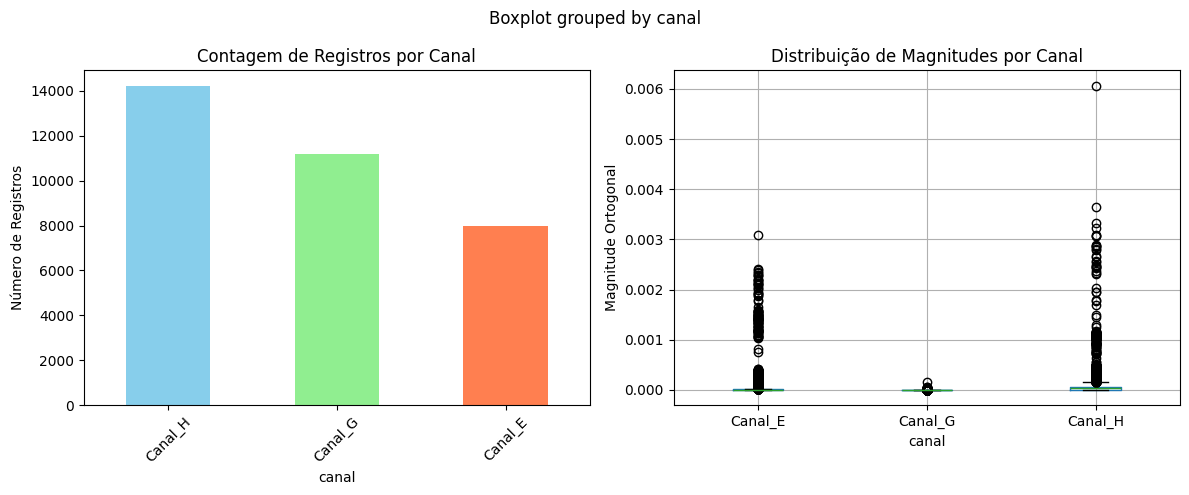

In [12]:
# üåê Analyze Results by Canal

print("=" * 60)
print("üåê AN√ÅLISE POR CANAL")
print("=" * 60)

try:
    print(f"\nüìä CONTAGEM POR CANAL:")
    canal_counts = summary_df['canal'].value_counts()
    total_records = len(summary_df)
    
    for canal, count in canal_counts.items():
        percentage = (count / total_records) * 100
        print(f"   ‚Ä¢ {canal}: {count:,} registros ({percentage:.1f}%)")
    
    # An√°lise estat√≠stica por canal
    print(f"\nüìà ESTAT√çSTICAS DE MAGNITUDE POR CANAL:")
    canal_stats = summary_df.groupby('canal')['max_magnitude'].agg([
        'count', 'mean', 'median', 'max', 'min', 'std'
    ]).round(6)
    
    print(canal_stats)
    
    # Compara√ß√£o entre canais para eventos com ambos
    events_with_both = summary_df[summary_df['event_id'].isin(
        summary_df.groupby('event_id').size()[summary_df.groupby('event_id').size() == 2].index
    )]
    
    if len(events_with_both) > 0:
        print(f"\nüîÑ AN√ÅLISE COMPARATIVA (eventos com ambos os canais):")
        
        # Pivot para ter H e G na mesma linha
        pivot_df = events_with_both.pivot(index='event_id', columns='canal', values='max_magnitude')
        
        # Comparar magnitudes
        if 'Canal_H' in pivot_df.columns and 'Canal_G' in pivot_df.columns:
            h_wins = (pivot_df['Canal_H'] > pivot_df['Canal_G']).sum()
            g_wins = (pivot_df['Canal_G'] > pivot_df['Canal_H']).sum()
            ties = (pivot_df['Canal_H'] == pivot_df['Canal_G']).sum()
            
            total_compared = len(pivot_df)
            
            print(f"   ‚Ä¢ Total de eventos comparados: {total_compared:,}")
            print(f"   ‚Ä¢ Canal H tem maior magnitude: {h_wins:,} ({h_wins/total_compared*100:.1f}%)")
            print(f"   ‚Ä¢ Canal G tem maior magnitude: {g_wins:,} ({g_wins/total_compared*100:.1f}%)")
            print(f"   ‚Ä¢ Empates: {ties:,} ({ties/total_compared*100:.1f}%)")
            
            # Raz√£o m√©dia entre canais
            ratio_h_g = (pivot_df['Canal_H'] / pivot_df['Canal_G']).replace([np.inf, -np.inf], np.nan)
            ratio_h_g = ratio_h_g.dropna()
            
            if len(ratio_h_g) > 0:
                print(f"   ‚Ä¢ Raz√£o m√©dia H/G: {ratio_h_g.mean():.2f}")
                print(f"   ‚Ä¢ Raz√£o mediana H/G: {ratio_h_g.median():.2f}")
    
    # Visualiza√ß√£o simples (se matplotlib estiver dispon√≠vel)
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Gr√°fico 1: Contagem por canal
        canal_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'lightgreen', 'coral'])
        ax1.set_title('Contagem de Registros por Canal')
        ax1.set_ylabel('N√∫mero de Registros')
        ax1.tick_params(axis='x', rotation=45)
        
        # Gr√°fico 2: Box plot de magnitudes por canal
        summary_df.boxplot(column='max_magnitude', by='canal', ax=ax2)
        ax2.set_title('Distribui√ß√£o de Magnitudes por Canal')
        ax2.set_ylabel('Magnitude Ortogonal')
        
        plt.tight_layout()
        plt.show()
        
    except:
        print("üìä (Gr√°ficos n√£o dispon√≠veis - instale matplotlib se necess√°rio)")
    
except NameError:
    print("‚ùå Erro: Execute primeiro as c√©lulas de processamento!")
except Exception as e:
    print(f"‚ùå Erro na an√°lise por canal: {e}")

üîß AN√ÅLISE POR SENSOR

üèÜ SENSORES MAIS FREQUENTES POR CANAL:

üîπ CANAL H (14,203 registros):
    1. BR.ESM01: 6,674 eventos (47.0%)
    2. BR.ESM08: 2,938 eventos (20.7%)
    3. BR.ESM05: 1,274 eventos (9.0%)
    4. BR.ESM07: 914 eventos (6.4%)
    5. BR.ESM03: 899 eventos (6.3%)
    6. BR.ESM10: 814 eventos (5.7%)
    7. BR.ESM02: 690 eventos (4.9%)

üîπ CANAL G (11,170 registros):
    1. BR.ESM04: 5,364 eventos (48.0%)
    2. BR.ESM09: 2,975 eventos (26.6%)
    3. BR.ESM06: 2,831 eventos (25.3%)

üîπ CANAL E (7,983 registros):
    1. SC.MAC14.00: 3,463 eventos (43.4%)
    2. SC.MAC13.00: 1,879 eventos (23.5%)
    3. SC.MAC12.00: 1,077 eventos (13.5%)
    4. SC.MAC11.00: 581 eventos (7.3%)
    5. SC.MAC15.00: 501 eventos (6.3%)
    6. SC.MAC04.00: 482 eventos (6.0%)

üåü RANKING GERAL DE SENSORES:
    1. BR.ESM01: 6,674 eventos (20.0%) - Canais: Canal_H
    2. BR.ESM04: 5,364 eventos (16.1%) - Canais: Canal_G
    3. SC.MAC14.00: 3,463 eventos (10.4%) - Canais: Canal_E
    4

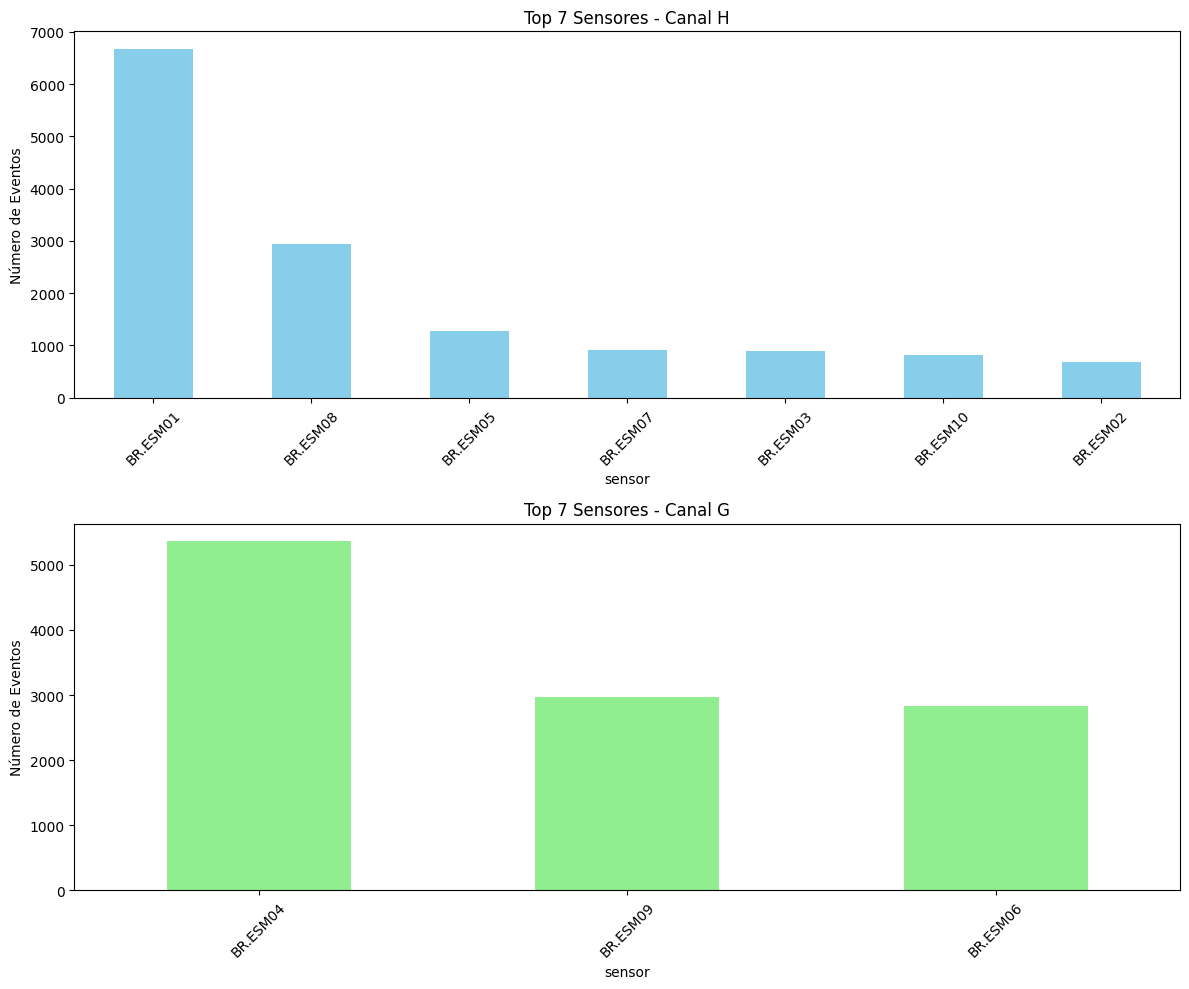

In [13]:
# üîß Analyze Results by Sensor

print("=" * 60)
print("üîß AN√ÅLISE POR SENSOR")
print("=" * 60)

try:
    print(f"\nüèÜ SENSORES MAIS FREQUENTES POR CANAL:")
    
    # An√°lise do Canal H
    h_data = summary_df[summary_df['canal'] == 'Canal_H']
    if len(h_data) > 0:
        print(f"\nüîπ CANAL H ({len(h_data):,} registros):")
        h_sensors = h_data['sensor'].value_counts()
        
        for i, (sensor, count) in enumerate(h_sensors.items(), 1):
            percentage = (count / len(h_data)) * 100
            print(f"   {i:2d}. {sensor}: {count:,} eventos ({percentage:.1f}%)")
    
    # An√°lise do Canal G
    g_data = summary_df[summary_df['canal'] == 'Canal_G']
    if len(g_data) > 0:
        print(f"\nüîπ CANAL G ({len(g_data):,} registros):")
        g_sensors = g_data['sensor'].value_counts()
        
        for i, (sensor, count) in enumerate(g_sensors.items(), 1):
            percentage = (count / len(g_data)) * 100
            print(f"   {i:2d}. {sensor}: {count:,} eventos ({percentage:.1f}%)")
    
    # An√°lise do Canal E (se existir)
    e_data = summary_df[summary_df['canal'] == 'Canal_E']
    if len(e_data) > 0:
        print(f"\nüîπ CANAL E ({len(e_data):,} registros):")
        e_sensors = e_data['sensor'].value_counts()
        
        for i, (sensor, count) in enumerate(e_sensors.items(), 1):
            percentage = (count / len(e_data)) * 100
            print(f"   {i:2d}. {sensor}: {count:,} eventos ({percentage:.1f}%)")
    
    # An√°lise geral de sensores
    print(f"\nüåü RANKING GERAL DE SENSORES:")
    all_sensors = summary_df['sensor'].value_counts()
    
    for i, (sensor, count) in enumerate(all_sensors.items(), 1):
        percentage = (count / len(summary_df)) * 100
        # Identificar em quais canais o sensor aparece
        sensor_canais = summary_df[summary_df['sensor'] == sensor]['canal'].unique()
        canais_str = ', '.join(sorted(sensor_canais))
        print(f"   {i:2d}. {sensor}: {count:,} eventos ({percentage:.1f}%) - Canais: {canais_str}")
    
    # Estat√≠sticas de magnitude por sensor (top 5)
    print(f"\nüìä ESTAT√çSTICAS DE MAGNITUDE (Top 5 sensores):")
    top_sensors = all_sensors.head(5).index
    
    for sensor in top_sensors:
        sensor_data = summary_df[summary_df['sensor'] == sensor]
        print(f"\nüî∏ {sensor} ({len(sensor_data):,} eventos):")
        print(f"   ‚Ä¢ Magnitude m√©dia: {sensor_data['max_magnitude'].mean():.2e}")
        print(f"   ‚Ä¢ Magnitude m√°xima: {sensor_data['max_magnitude'].max():.2e}")
        print(f"   ‚Ä¢ Magnitude m√≠nima: {sensor_data['max_magnitude'].min():.2e}")
        print(f"   ‚Ä¢ Desvio padr√£o: {sensor_data['max_magnitude'].std():.2e}")
    
    # Visualiza√ß√£o (se poss√≠vel)
    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Gr√°fico 1: Sensores por canal H
        if len(h_data) > 0:
            h_sensors.head(7).plot(kind='bar', ax=ax1, color='skyblue')
            ax1.set_title('Top 7 Sensores - Canal H')
            ax1.set_ylabel('N√∫mero de Eventos')
            ax1.tick_params(axis='x', rotation=45)
        
        # Gr√°fico 2: Sensores por canal G
        if len(g_data) > 0:
            g_sensors.head(7).plot(kind='bar', ax=ax2, color='lightgreen')
            ax2.set_title('Top 7 Sensores - Canal G')
            ax2.set_ylabel('N√∫mero de Eventos')
            ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    except:
        print("üìä (Gr√°ficos n√£o dispon√≠veis - instale matplotlib se necess√°rio)")
    
except NameError:
    print("‚ùå Erro: Execute primeiro as c√©lulas de processamento!")
except Exception as e:
    print(f"‚ùå Erro na an√°lise por sensor: {e}")

üìà ESTAT√çSTICAS DETALHADAS DE MAGNITUDE

üåü ESTAT√çSTICAS GERAIS:
   ‚Ä¢ Magnitude m√©dia geral: 4.29e-05
   ‚Ä¢ Magnitude mediana geral: 7.39e-06
   ‚Ä¢ Magnitude m√°xima geral: 6.07e-03
   ‚Ä¢ Magnitude m√≠nima geral: 3.73e-07
   ‚Ä¢ Desvio padr√£o geral: 1.48e-04

üîπ ESTAT√çSTICAS CANAL H:
   ‚Ä¢ Magnitude m√©dia: 6.86e-05
   ‚Ä¢ Magnitude mediana: 4.47e-05
   ‚Ä¢ Magnitude m√°xima: 6.07e-03
   ‚Ä¢ Magnitude m√≠nima: 1.10e-06
   ‚Ä¢ Desvio padr√£o: 1.71e-04

üîπ ESTAT√çSTICAS CANAL G:
   ‚Ä¢ Magnitude m√©dia: 1.83e-06
   ‚Ä¢ Magnitude mediana: 8.95e-07
   ‚Ä¢ Magnitude m√°xima: 1.58e-04
   ‚Ä¢ Magnitude m√≠nima: 3.73e-07
   ‚Ä¢ Desvio padr√£o: 3.44e-06

‚öñÔ∏è COMPARA√á√ÉO ENTRE CANAIS:
   ‚Ä¢ Raz√£o das m√©dias (H/G): 37.41
   ‚Ä¢ Canal H √© ~37x maior que Canal G em m√©dia

üèÜ TOP 10 EVENTOS COM MAIOR MAGNITUDE:
    1¬∫ Event 208196 | Canal_H  | BR.ESM05   | Magnitude: 6.07e-03
    2¬∫ Event   4664 | Canal_H  | BR.ESM03   | Magnitude: 3.64e-03
    3¬∫ Event 206057 | Cana

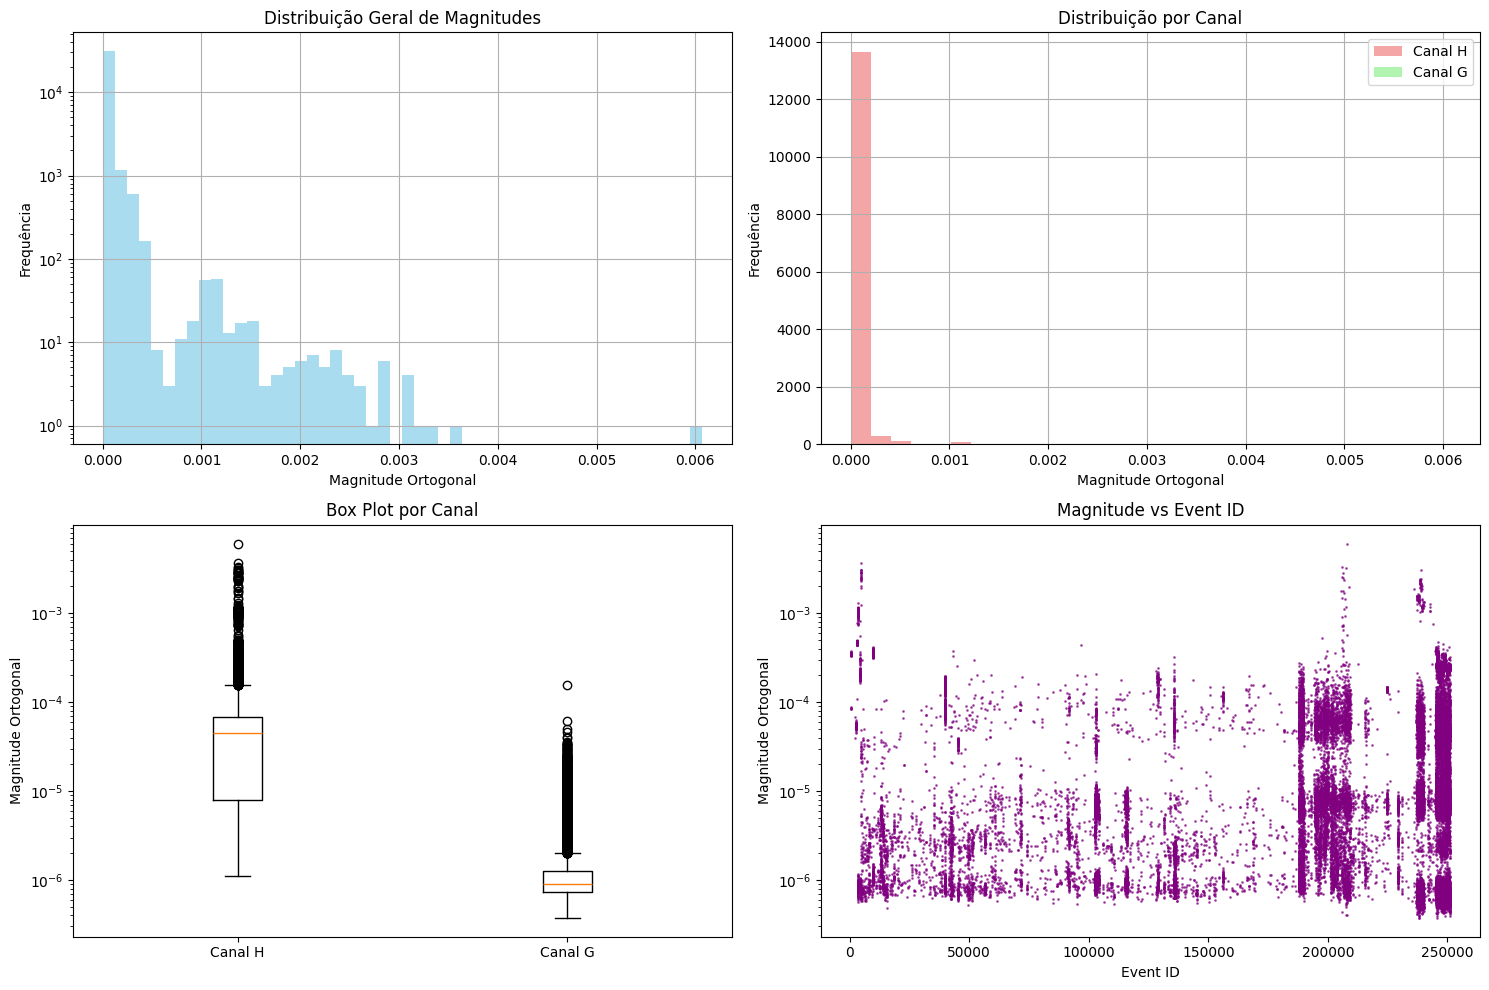


‚úÖ An√°lise de magnitude conclu√≠da!


In [14]:
# üìà Display Magnitude Statistics

print("=" * 60)
print("üìà ESTAT√çSTICAS DETALHADAS DE MAGNITUDE")
print("=" * 60)

try:
    # Estat√≠sticas gerais de magnitude
    print(f"\nüåü ESTAT√çSTICAS GERAIS:")
    print(f"   ‚Ä¢ Magnitude m√©dia geral: {summary_df['max_magnitude'].mean():.2e}")
    print(f"   ‚Ä¢ Magnitude mediana geral: {summary_df['max_magnitude'].median():.2e}")
    print(f"   ‚Ä¢ Magnitude m√°xima geral: {summary_df['max_magnitude'].max():.2e}")
    print(f"   ‚Ä¢ Magnitude m√≠nima geral: {summary_df['max_magnitude'].min():.2e}")
    print(f"   ‚Ä¢ Desvio padr√£o geral: {summary_df['max_magnitude'].std():.2e}")
    
    # Estat√≠sticas por canal
    h_data = summary_df[summary_df['canal'] == 'Canal_H']
    g_data = summary_df[summary_df['canal'] == 'Canal_G']
    
    if len(h_data) > 0:
        print(f"\nüîπ ESTAT√çSTICAS CANAL H:")
        print(f"   ‚Ä¢ Magnitude m√©dia: {h_data['max_magnitude'].mean():.2e}")
        print(f"   ‚Ä¢ Magnitude mediana: {h_data['max_magnitude'].median():.2e}")
        print(f"   ‚Ä¢ Magnitude m√°xima: {h_data['max_magnitude'].max():.2e}")
        print(f"   ‚Ä¢ Magnitude m√≠nima: {h_data['max_magnitude'].min():.2e}")
        print(f"   ‚Ä¢ Desvio padr√£o: {h_data['max_magnitude'].std():.2e}")
    
    if len(g_data) > 0:
        print(f"\nüîπ ESTAT√çSTICAS CANAL G:")
        print(f"   ‚Ä¢ Magnitude m√©dia: {g_data['max_magnitude'].mean():.2e}")
        print(f"   ‚Ä¢ Magnitude mediana: {g_data['max_magnitude'].median():.2e}")
        print(f"   ‚Ä¢ Magnitude m√°xima: {g_data['max_magnitude'].max():.2e}")
        print(f"   ‚Ä¢ Magnitude m√≠nima: {g_data['max_magnitude'].min():.2e}")
        print(f"   ‚Ä¢ Desvio padr√£o: {g_data['max_magnitude'].std():.2e}")
    
    # Compara√ß√£o entre canais
    if len(h_data) > 0 and len(g_data) > 0:
        ratio_means = h_data['max_magnitude'].mean() / g_data['max_magnitude'].mean()
        print(f"\n‚öñÔ∏è COMPARA√á√ÉO ENTRE CANAIS:")
        print(f"   ‚Ä¢ Raz√£o das m√©dias (H/G): {ratio_means:.2f}")
        print(f"   ‚Ä¢ Canal H √© ~{ratio_means:.0f}x maior que Canal G em m√©dia")
    
    # Top 10 eventos com maior magnitude
    print(f"\nüèÜ TOP 10 EVENTOS COM MAIOR MAGNITUDE:")
    top_events = summary_df.nlargest(10, 'max_magnitude')
    
    for i, (_, row) in enumerate(top_events.iterrows(), 1):
        print(f"   {i:2d}¬∫ Event {row['event_id']:6d} | {row['canal']:8s} | "
              f"{row['sensor']:10s} | Magnitude: {row['max_magnitude']:.2e}")
    
    # Distribui√ß√£o de magnitudes
    print(f"\nüìä DISTRIBUI√á√ÉO DE MAGNITUDES:")
    
    # Percentis
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print("   Percentis:")
    for p in percentiles:
        value = np.percentile(summary_df['max_magnitude'], p)
        print(f"     ‚Ä¢ {p:2d}%: {value:.2e}")
    
    # Faixas de magnitude
    print(f"\nüìà AN√ÅLISE POR FAIXAS DE MAGNITUDE:")
    
    # Definir faixas baseadas nos percentis
    q25 = summary_df['max_magnitude'].quantile(0.25)
    q50 = summary_df['max_magnitude'].quantile(0.50)
    q75 = summary_df['max_magnitude'].quantile(0.75)
    q95 = summary_df['max_magnitude'].quantile(0.95)
    
    baixa = (summary_df['max_magnitude'] <= q25).sum()
    media = ((summary_df['max_magnitude'] > q25) & (summary_df['max_magnitude'] <= q75)).sum()
    alta = ((summary_df['max_magnitude'] > q75) & (summary_df['max_magnitude'] <= q95)).sum()
    muito_alta = (summary_df['max_magnitude'] > q95).sum()
    
    total = len(summary_df)
    
    print(f"   ‚Ä¢ Magnitude baixa (‚â§ Q25): {baixa:,} eventos ({baixa/total*100:.1f}%)")
    print(f"   ‚Ä¢ Magnitude m√©dia (Q25-Q75): {media:,} eventos ({media/total*100:.1f}%)")
    print(f"   ‚Ä¢ Magnitude alta (Q75-Q95): {alta:,} eventos ({alta/total*100:.1f}%)")
    print(f"   ‚Ä¢ Magnitude muito alta (> Q95): {muito_alta:,} eventos ({muito_alta/total*100:.1f}%)")
    
    # Visualiza√ß√£o das distribui√ß√µes
    try:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Histograma geral
        summary_df['max_magnitude'].hist(bins=50, ax=ax1, alpha=0.7, color='skyblue')
        ax1.set_title('Distribui√ß√£o Geral de Magnitudes')
        ax1.set_xlabel('Magnitude Ortogonal')
        ax1.set_ylabel('Frequ√™ncia')
        ax1.set_yscale('log')
        
        # Histograma por canal
        if len(h_data) > 0:
            h_data['max_magnitude'].hist(bins=30, ax=ax2, alpha=0.7, color='lightcoral', label='Canal H')
        if len(g_data) > 0:
            g_data['max_magnitude'].hist(bins=30, ax=ax2, alpha=0.7, color='lightgreen', label='Canal G')
        ax2.set_title('Distribui√ß√£o por Canal')
        ax2.set_xlabel('Magnitude Ortogonal')
        ax2.set_ylabel('Frequ√™ncia')
        ax2.legend()
        
        # Box plot por canal
        if len(h_data) > 0 and len(g_data) > 0:
            data_for_box = [h_data['max_magnitude'], g_data['max_magnitude']]
            ax3.boxplot(data_for_box, labels=['Canal H', 'Canal G'])
            ax3.set_title('Box Plot por Canal')
            ax3.set_ylabel('Magnitude Ortogonal')
            ax3.set_yscale('log')
        
        # Scatter plot (magnitude vs event_id)
        ax4.scatter(summary_df['event_id'], summary_df['max_magnitude'], 
                   alpha=0.6, s=1, c='purple')
        ax4.set_title('Magnitude vs Event ID')
        ax4.set_xlabel('Event ID')
        ax4.set_ylabel('Magnitude Ortogonal')
        ax4.set_yscale('log')
        
        plt.tight_layout()
        plt.show()
        
    except:
        print("üìä (Gr√°ficos n√£o dispon√≠veis - instale matplotlib se necess√°rio)")
    
    print(f"\n‚úÖ An√°lise de magnitude conclu√≠da!")
    
except NameError:
    print("‚ùå Erro: Execute primeiro as c√©lulas de processamento!")
except Exception as e:
    print(f"‚ùå Erro na an√°lise de magnitude: {e}")

üìä HISTOGRAMAS - EVENT ID vs MAGNITUDES ORTOGONAIS
üìã Dados dispon√≠veis:
   ‚Ä¢ Canal H: 14,203 eventos
   ‚Ä¢ Canal G: 11,170 eventos


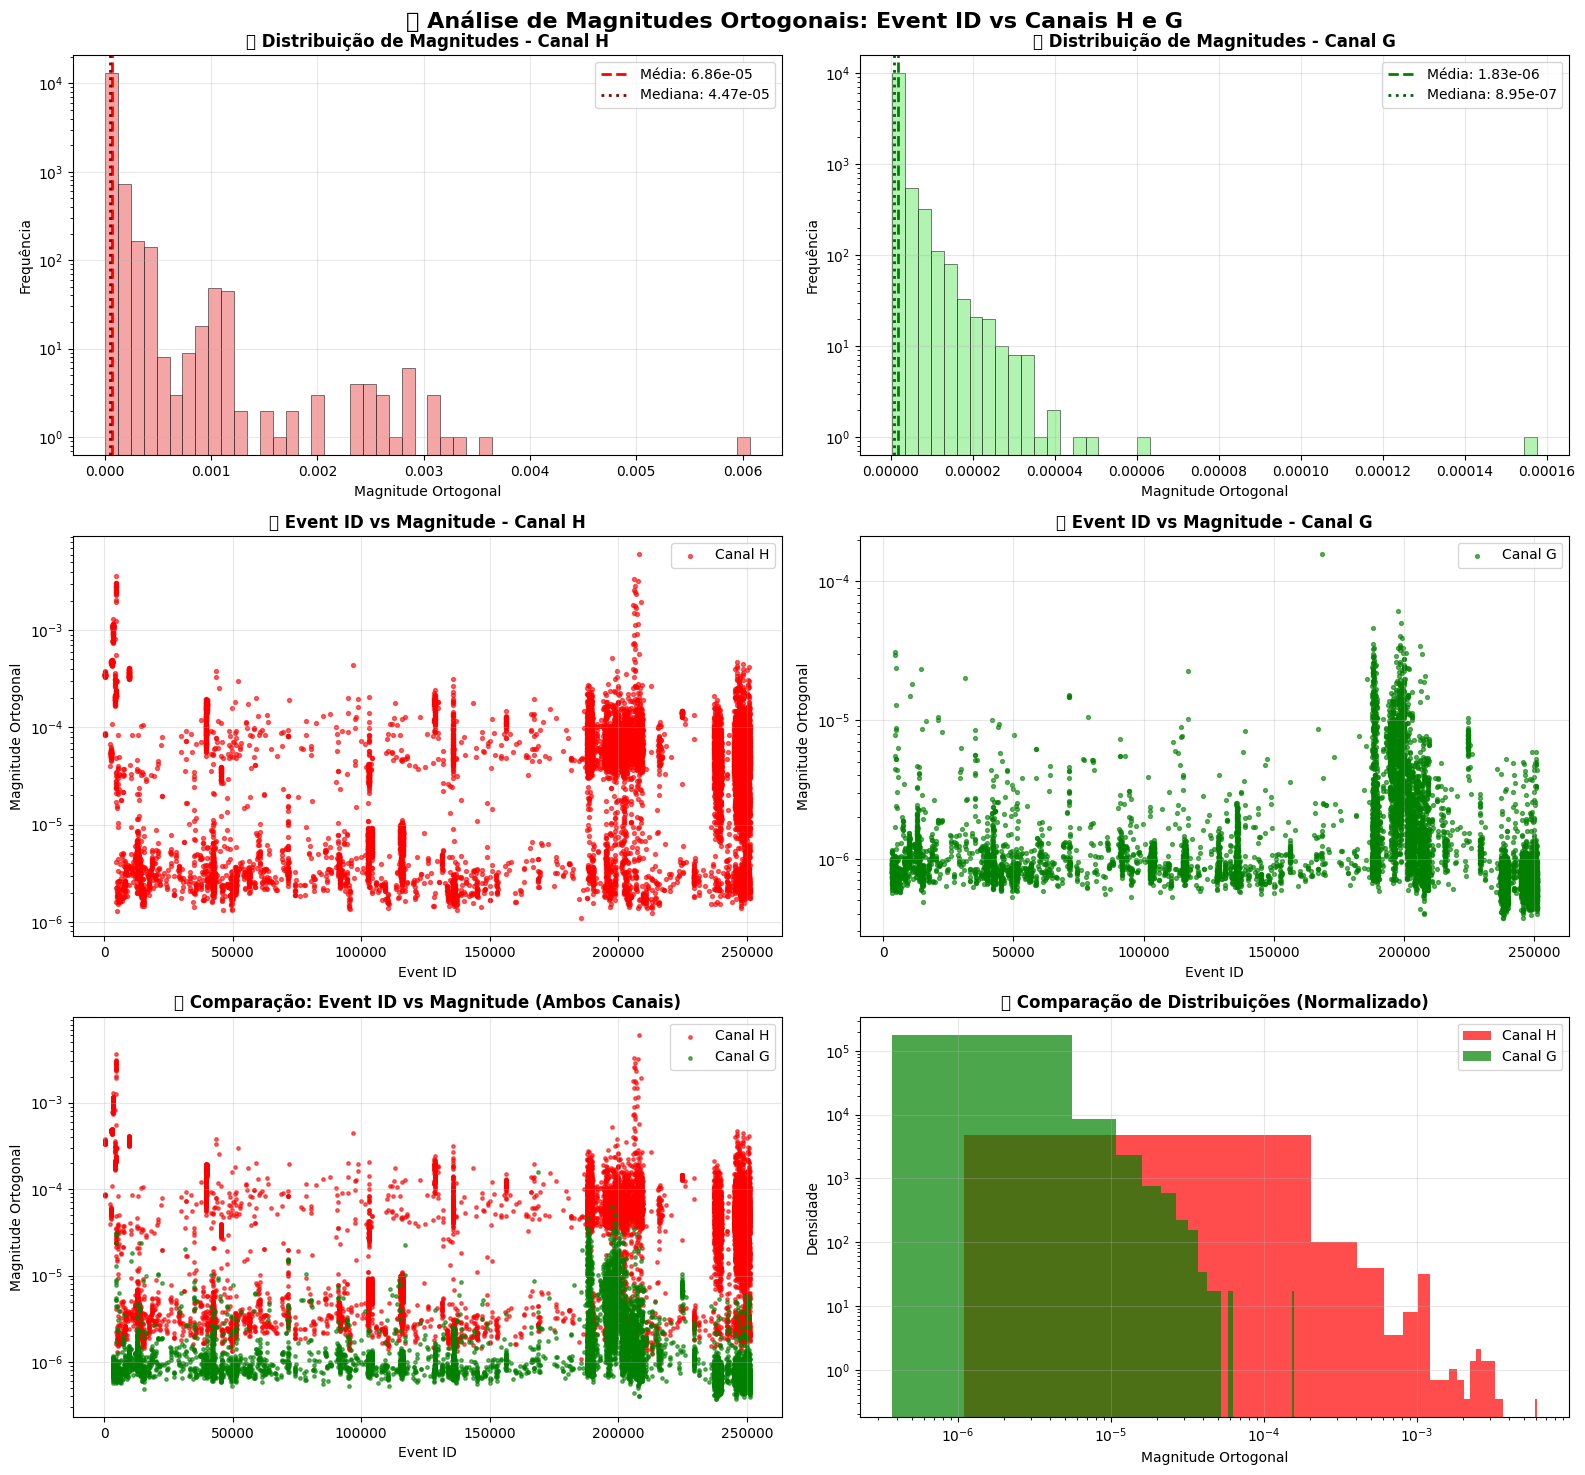


üìà ESTAT√çSTICAS RESUMIDAS:

üîπ CANAL H:
   ‚Ä¢ Eventos: 14,203
   ‚Ä¢ Magnitude m√©dia: 6.86e-05
   ‚Ä¢ Magnitude mediana: 4.47e-05
   ‚Ä¢ Magnitude m√°xima: 6.07e-03
   ‚Ä¢ Magnitude m√≠nima: 1.10e-06
   ‚Ä¢ Range de Event IDs: 359 - 251148

üîπ CANAL G:
   ‚Ä¢ Eventos: 11,170
   ‚Ä¢ Magnitude m√©dia: 1.83e-06
   ‚Ä¢ Magnitude mediana: 8.95e-07
   ‚Ä¢ Magnitude m√°xima: 1.58e-04
   ‚Ä¢ Magnitude m√≠nima: 3.73e-07
   ‚Ä¢ Range de Event IDs: 3384 - 251148

‚öñÔ∏è COMPARA√á√ÉO:
   ‚Ä¢ Raz√£o das m√©dias (H/G): 37.41
   ‚Ä¢ Canal H √© 37.4x maior que Canal G em m√©dia

‚úÖ Histogramas gerados com sucesso!
üí° Dica: No Colab, os gr√°ficos aparecer√£o automaticamente abaixo desta c√©lula


In [15]:
# üìä Histogramas: Event ID vs Magnitudes Ortogonais (Canais H e G)

print("=" * 60)
print("üìä HISTOGRAMAS - EVENT ID vs MAGNITUDES ORTOGONAIS")
print("=" * 60)

try:
    # Verificar se temos dados para trabalhar
    if 'summary_df' not in locals():
        print("‚ùå Erro: Execute primeiro as c√©lulas de processamento!")
    else:
        # Separar dados por canal
        h_data = summary_df[summary_df['canal'] == 'Canal_H'].copy()
        g_data = summary_df[summary_df['canal'] == 'Canal_G'].copy()
        
        print(f"üìã Dados dispon√≠veis:")
        print(f"   ‚Ä¢ Canal H: {len(h_data):,} eventos")
        print(f"   ‚Ä¢ Canal G: {len(g_data):,} eventos")
        
        # Configurar matplotlib para melhor visualiza√ß√£o
        plt.style.use('default')
        plt.rcParams['figure.figsize'] = (15, 12)
        
        # Criar subplots
        fig, axes = plt.subplots(3, 2, figsize=(16, 15))
        fig.suptitle('üìä An√°lise de Magnitudes Ortogonais: Event ID vs Canais H e G', 
                     fontsize=16, fontweight='bold', y=0.98)
        
        # 1. Histograma das magnitudes - Canal H
        if len(h_data) > 0:
            axes[0, 0].hist(h_data['max_magnitude'], bins=50, alpha=0.7, 
                           color='lightcoral', edgecolor='black', linewidth=0.5)
            axes[0, 0].set_title('üîπ Distribui√ß√£o de Magnitudes - Canal H', fontweight='bold')
            axes[0, 0].set_xlabel('Magnitude Ortogonal')
            axes[0, 0].set_ylabel('Frequ√™ncia')
            axes[0, 0].set_yscale('log')
            axes[0, 0].grid(True, alpha=0.3)
            
            # Adicionar estat√≠sticas no gr√°fico
            mean_h = h_data['max_magnitude'].mean()
            median_h = h_data['max_magnitude'].median()
            axes[0, 0].axvline(mean_h, color='red', linestyle='--', linewidth=2, label=f'M√©dia: {mean_h:.2e}')
            axes[0, 0].axvline(median_h, color='darkred', linestyle=':', linewidth=2, label=f'Mediana: {median_h:.2e}')
            axes[0, 0].legend()
        
        # 2. Histograma das magnitudes - Canal G
        if len(g_data) > 0:
            axes[0, 1].hist(g_data['max_magnitude'], bins=50, alpha=0.7, 
                           color='lightgreen', edgecolor='black', linewidth=0.5)
            axes[0, 1].set_title('üîπ Distribui√ß√£o de Magnitudes - Canal G', fontweight='bold')
            axes[0, 1].set_xlabel('Magnitude Ortogonal')
            axes[0, 1].set_ylabel('Frequ√™ncia')
            axes[0, 1].set_yscale('log')
            axes[0, 1].grid(True, alpha=0.3)
            
            # Adicionar estat√≠sticas no gr√°fico
            mean_g = g_data['max_magnitude'].mean()
            median_g = g_data['max_magnitude'].median()
            axes[0, 1].axvline(mean_g, color='green', linestyle='--', linewidth=2, label=f'M√©dia: {mean_g:.2e}')
            axes[0, 1].axvline(median_g, color='darkgreen', linestyle=':', linewidth=2, label=f'Mediana: {median_g:.2e}')
            axes[0, 1].legend()
        
        # 3. Scatter plot: Event ID vs Magnitude - Canal H
        if len(h_data) > 0:
            scatter_h = axes[1, 0].scatter(h_data['event_id'], h_data['max_magnitude'], 
                                          alpha=0.6, s=8, c='red', label='Canal H')
            axes[1, 0].set_title('üîπ Event ID vs Magnitude - Canal H', fontweight='bold')
            axes[1, 0].set_xlabel('Event ID')
            axes[1, 0].set_ylabel('Magnitude Ortogonal')
            axes[1, 0].set_yscale('log')
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].legend()
        
        # 4. Scatter plot: Event ID vs Magnitude - Canal G
        if len(g_data) > 0:
            scatter_g = axes[1, 1].scatter(g_data['event_id'], g_data['max_magnitude'], 
                                          alpha=0.6, s=8, c='green', label='Canal G')
            axes[1, 1].set_title('üîπ Event ID vs Magnitude - Canal G', fontweight='bold')
            axes[1, 1].set_xlabel('Event ID')
            axes[1, 1].set_ylabel('Magnitude Ortogonal')
            axes[1, 1].set_yscale('log')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].legend()
        
        # 5. Compara√ß√£o direta: Ambos os canais no mesmo gr√°fico
        if len(h_data) > 0 and len(g_data) > 0:
            axes[2, 0].scatter(h_data['event_id'], h_data['max_magnitude'], 
                              alpha=0.6, s=6, c='red', label='Canal H')
            axes[2, 0].scatter(g_data['event_id'], g_data['max_magnitude'], 
                              alpha=0.6, s=6, c='green', label='Canal G')
            axes[2, 0].set_title('üîπ Compara√ß√£o: Event ID vs Magnitude (Ambos Canais)', fontweight='bold')
            axes[2, 0].set_xlabel('Event ID')
            axes[2, 0].set_ylabel('Magnitude Ortogonal')
            axes[2, 0].set_yscale('log')
            axes[2, 0].grid(True, alpha=0.3)
            axes[2, 0].legend()
        
        # 6. Histograma comparativo das magnitudes
        if len(h_data) > 0 and len(g_data) > 0:
            axes[2, 1].hist(h_data['max_magnitude'], bins=30, alpha=0.7, 
                           color='red', label='Canal H', density=True)
            axes[2, 1].hist(g_data['max_magnitude'], bins=30, alpha=0.7, 
                           color='green', label='Canal G', density=True)
            axes[2, 1].set_title('üîπ Compara√ß√£o de Distribui√ß√µes (Normalizado)', fontweight='bold')
            axes[2, 1].set_xlabel('Magnitude Ortogonal')
            axes[2, 1].set_ylabel('Densidade')
            axes[2, 1].set_yscale('log')
            axes[2, 1].set_xscale('log')
            axes[2, 1].grid(True, alpha=0.3)
            axes[2, 1].legend()
        
        # Ajustar layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()
        
        # Estat√≠sticas resumidas
        print(f"\nüìà ESTAT√çSTICAS RESUMIDAS:")
        
        if len(h_data) > 0:
            print(f"\nüîπ CANAL H:")
            print(f"   ‚Ä¢ Eventos: {len(h_data):,}")
            print(f"   ‚Ä¢ Magnitude m√©dia: {h_data['max_magnitude'].mean():.2e}")
            print(f"   ‚Ä¢ Magnitude mediana: {h_data['max_magnitude'].median():.2e}")
            print(f"   ‚Ä¢ Magnitude m√°xima: {h_data['max_magnitude'].max():.2e}")
            print(f"   ‚Ä¢ Magnitude m√≠nima: {h_data['max_magnitude'].min():.2e}")
            print(f"   ‚Ä¢ Range de Event IDs: {h_data['event_id'].min()} - {h_data['event_id'].max()}")
        
        if len(g_data) > 0:
            print(f"\nüîπ CANAL G:")
            print(f"   ‚Ä¢ Eventos: {len(g_data):,}")
            print(f"   ‚Ä¢ Magnitude m√©dia: {g_data['max_magnitude'].mean():.2e}")
            print(f"   ‚Ä¢ Magnitude mediana: {g_data['max_magnitude'].median():.2e}")
            print(f"   ‚Ä¢ Magnitude m√°xima: {g_data['max_magnitude'].max():.2e}")
            print(f"   ‚Ä¢ Magnitude m√≠nima: {g_data['max_magnitude'].min():.2e}")
            print(f"   ‚Ä¢ Range de Event IDs: {g_data['event_id'].min()} - {g_data['event_id'].max()}")
        
        if len(h_data) > 0 and len(g_data) > 0:
            ratio_means = h_data['max_magnitude'].mean() / g_data['max_magnitude'].mean()
            print(f"\n‚öñÔ∏è COMPARA√á√ÉO:")
            print(f"   ‚Ä¢ Raz√£o das m√©dias (H/G): {ratio_means:.2f}")
            print(f"   ‚Ä¢ Canal H √© {ratio_means:.1f}x maior que Canal G em m√©dia")
        
        print(f"\n‚úÖ Histogramas gerados com sucesso!")
        print(f"üí° Dica: No Colab, os gr√°ficos aparecer√£o automaticamente abaixo desta c√©lula")

except ImportError:
    print("‚ùå Erro: matplotlib n√£o est√° dispon√≠vel!")
    print("üí° No Google Colab, execute: !pip install matplotlib")
except Exception as e:
    print(f"‚ùå Erro ao gerar histogramas: {e}")
    print(f"üí° Certifique-se de que as c√©lulas anteriores foram executadas com sucesso")

## üìä **Compara√ß√£o de Visualiza√ß√µes: Canal H vs Canal G**

Esta se√ß√£o compara diretamente as caracter√≠sticas dos dois canais (H e G) atrav√©s de m√∫ltiplas visualiza√ß√µes:

### **üîç An√°lises Inclu√≠das:**

1. **üìà Distribui√ß√µes de Magnitude**: Histogramas separados e sobrepostos para comparar as distribui√ß√µes
2. **üéØ Scatter Plots**: Event ID vs Magnitude para identificar padr√µes temporais
3. **‚öñÔ∏è An√°lise Comparativa**: Visualiza√ß√µes lado a lado para facilitar a compara√ß√£o
4. **üìä Estat√≠sticas Descritivas**: M√©dias, medianas, m√°ximos e m√≠nimos para cada canal

### **üé® Caracter√≠sticas dos Gr√°ficos:**

- **Escala Logar√≠tmica**: Facilita a visualiza√ß√£o de dados com grande varia√ß√£o
- **Cores Distintivas**: Vermelho para Canal H, Verde para Canal G
- **Transpar√™ncia**: Permite visualizar sobreposi√ß√µes de dados
- **Estat√≠sticas Visuais**: Linhas de m√©dia e mediana nos histogramas

### **üí° Como Interpretar:**

- **Dispers√£o dos Pontos**: Indica a variabilidade das magnitudes
- **Densidade dos Histogramas**: Mostra a concentra√ß√£o de valores
- **Compara√ß√£o Visual**: Permite identificar qual canal tem magnitudes dominantes